Model Independent Method to extract $c_i, s_i$ and $x_\pm, y_\pm$ from $D \to K_S^0 \pi^+ \pi^-$ decays.
===

We start by defining our binning scheme and binning the data


## Binning

In [82]:
#Import necessary parts

import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import iminuit
import scipy.stats
import uproot


We take a "reference" sample, which we use `AmpGen` to print out ($m_-^2, m_+^2, \Delta \delta_D$) values as a `csv` file, called `reference.csv`. We use `getDD` to make this into a `DataFrame`, `refDD`.





In [83]:
def getDD(fileName):
    s01 = []
    s02 = []
    dd = []
    Fp = []
    Fm = []
    with open(fileName) as f:
        for line in f:
            a = line.split()
            _s01 = float(a[0])
            _s02 = float(a[1])
            _dd = float(a[3])
            _Fp = float(a[11])
            _Fm = float(a[15]) 
            s01.append(_s01)
            s02.append(_s02)
            dd.append(_dd)
            Fp.append(_Fp**2)
            Fm.append(_Fm**2)
            
    return pd.DataFrame({"s01":s01, "s02":s02, "dd":dd, "Fp":Fp,"Fm":Fm})
                        
refDD = getDD("reference.csv")

We can plot $\Delta \delta_D(m_-^2,m_+^2)$ from this, using `plotDD`

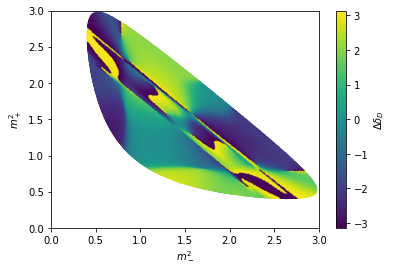

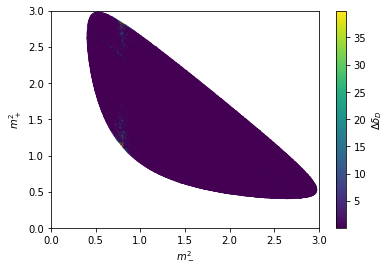

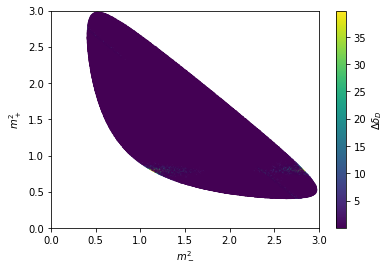

In [84]:
def plotDD(df, xlims=[0,3], ylims=[0,3],c="dd"):
    x = df["s01"]
    y = df["s02"]
    z = df[c]
    f, a = plt.subplots(1,1)
    sc = a.scatter(x, y, c=z, s=0.01, marker="x")
    plt.xlim(xlims[0], xlims[1])
    plt.ylim(ylims[0], ylims[1])
    a.set_xlabel(r"$m_-^2$")
    a.set_ylabel(r"$m_+^2$")
    plt.colorbar(sc, ax=a, label=r"$\Delta \delta_D$")
    
    
plotDD(refDD)
plotDD(refDD,c="Fp")
plotDD(refDD,c="Fm")
FpSum = refDD["Fp"].sum()
FmSum = refDD["Fm"].sum()



We can define bins (using an equal binning scheme for $\Delta \delta_D$ using the `equalBinning` function, which takes the `refDD` `pandas.DataFrame` and selects the portion of `refDD` with $\Delta \delta_D$ inside bin $i$. 

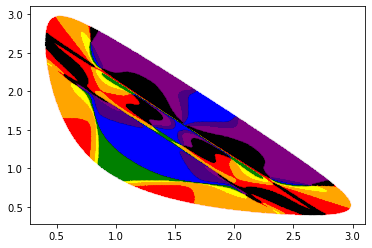

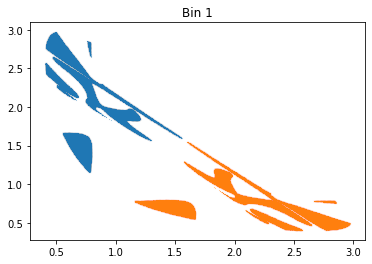

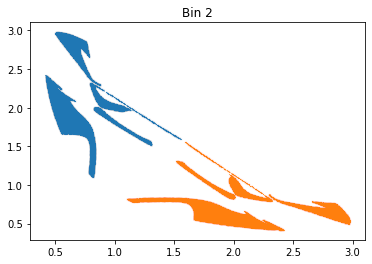

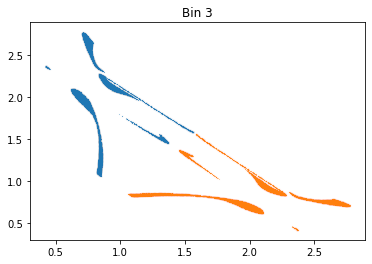

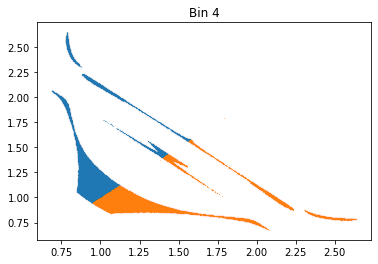

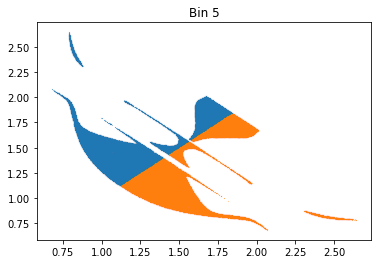

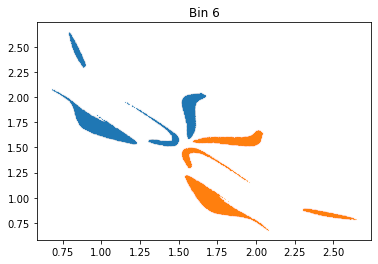

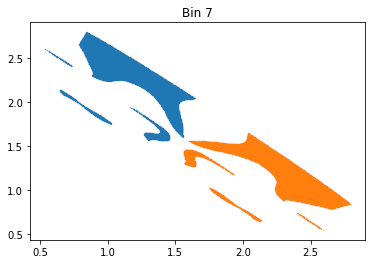

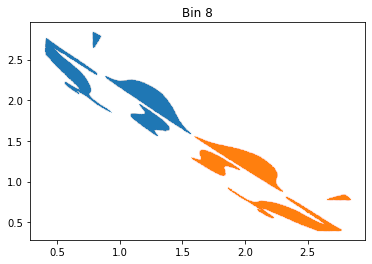

In [85]:
def equalBinning(df, i, j=1):

    if j>0:
        eqDD = np.linspace(-np.pi, np.pi, 9)

    

        s01_bins = {}
        s02_bins = {}
        dd_bins = {}
        #For bin 0

        dd = df["dd"]

        cond0 = df["dd"] > eqDD[i-1]
        cond1 = df["dd"] < eqDD[i]
        cond2 = df["s02"] >= df["s01"]
        

        dd0 = df[ cond0 & cond1 & cond2 ]
        
        return dd0
    else:
        eqDD = np.linspace(-np.pi, np.pi, 9)

   

        s01_bins = {}
        s02_bins = {}
        dd_bins = {}
        #For bin 0

        dd = df["dd"]

        cond0 = df["dd"] > eqDD[i-1]
        cond1 = df["dd"] < eqDD[i]
        cond2 = df["s02"] <= df["s01"]
        

        dd0 = df[ cond0 & cond1 & cond2 ]
        
        return dd0

f0, a0 = plt.subplots(1,1)
colors = "red orange yellow green blue indigo purple black".split()
for i in range(1,9):
    df_Bin_plus = equalBinning(refDD, i, 1)
    df_Bin_minus = equalBinning(refDD, 9-i, -1)

    f,a=plt.subplots(1,1)

    xp, yp, ddp, FpP, FmP = df_Bin_plus.T.values
    xm, ym, ddm, FpM, FmM = df_Bin_minus.T.values
    
    a.scatter(xp,yp, s=0.01, marker="x")
    a.scatter(xm,ym, s=0.01, marker="x")
    a0.scatter(xp,yp, s=0.01, marker="x", c=colors[i-1])
    a0.scatter(xm,ym, s=0.01, marker="x", c=colors[i-1])
    a.set_title(f"Bin {i}")



So we can make the `ref_bins`, a dictionary where each key is the bin and the entry is the `DataFrame` with the ($m_-^2$, $m_+^2$)'s that correspond to that bin.

In [86]:
def reference_eq_binning(fileName, number):
    df = getDD(fileName)
    output = {}

    s01, s02, dd = df["s01"], df["s02"], df["dd"]

    for i in range(1,number+1):
        ddip = equalBinning(df, i, 1)
        ddim = equalBinning(df, number+1-i, -1)
        output[f"{i}"] = ddip
        output[f"-{i}"] = ddim
    return output



ref_bins = reference_eq_binning("reference.csv", 8)
print(ref_bins)

{'1':              s01      s02       dd        Fp        Fm
0       0.702607  1.49052 -2.57581  1.370445  0.084175
3       1.036560  1.94265 -2.51693  0.006085  0.004894
7       0.507797  2.67124 -3.09377  2.145375  1.707256
22      0.612246  1.49246 -2.63681  0.558861  0.079293
27      0.761850  1.54603 -2.44030  3.169717  0.068184
...          ...      ...      ...       ...       ...
672377  0.794000  2.01902 -2.71518  0.001247  0.000270
672439  0.710423  1.40845 -2.63164  0.042214  0.002636
672441  0.607883  2.56525 -3.04257  0.053152  0.034907
672476  1.081550  1.82508 -3.12658  0.000104  0.000041
672479  0.445691  2.45585 -2.98285  0.000738  0.000526

[58633 rows x 5 columns], '-1':             s01       s02       dd        Fp        Fm
5       2.49245  0.714854  2.58003  0.809127  2.124948
13      1.59373  0.708169  2.45156  0.051937  0.997102
23      1.46274  0.763171  2.49449  0.106591  4.521024
45      1.51020  0.622789  2.60639  0.073352  0.569338
47      1.47749  0.659114 

Now we have $\Delta \delta_D$ in bins, we can obtain the mean value for $\cos(\Delta \delta_D)$ and $\sin(\Delta \delta_D)$, for each bin $i$


i	ci	si	F_i	F_-i
1	-0.895	-0.376	3.133	3.176
2	-0.374	-0.901	3.196	3.164
3	0.301	-0.926	0.774	0.789
4	0.948	-0.227	0.338	0.331
5	0.932	0.283	0.088	0.086
6	0.411	0.884	0.138	0.15
7	-0.485	0.858	0.947	0.968
8	-0.904	0.335	1.561	1.512


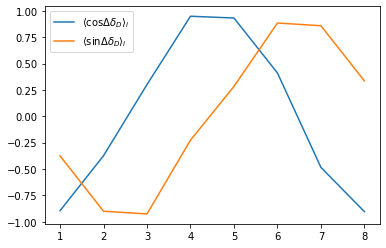

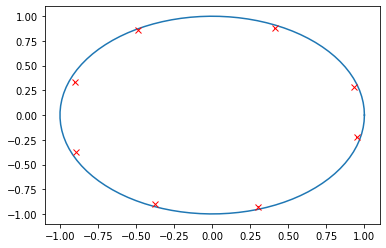

In [87]:
ci = {}
dci = {}
si = {}
dsi = {}

Fpi = {}
Fmi = {}
for i in range(1,9):
    _ci, _si, _Fpi, _Fmi = [],[],0,0
    ddp = ref_bins[f"{i}"]["dd"].values
    ddm = ref_bins[f"{-i}"]["dd"].values
    
    FpP = ref_bins[f"{i}"]["Fp"].values
    FpM = ref_bins[f"{-i}"]["Fp"].values
    
    FmP = ref_bins[f"{i}"]["Fm"].values
    FmM = ref_bins[f"{-i}"]["Fm"].values
    
    Np = len(ddp)
    Nm = len(ddm)
    _N = Np + Nm
    for dd in ddp:
        _ci.append(np.cos(dd))
        _si.append(np.sin(dd))
    for dd in ddm:
        _ci.append(np.cos(dd))
        _si.append(-np.sin(dd))
        
    for fpp in FpP:
        _Fpi += fpp**2
        
    for fpm in FpM:
        _Fpi += fpm**2
        
    for fmp in FmP:
        _Fmi += fmp**2
        
    for fmm in FmM:
        _Fmi += fmm**2
        
        
    _ci = np.array(_ci)
    _si = np.array(_si)
    
        
    ci[f"{i}"] = np.mean(_ci)
    dci[f"{i}"] = np.std(_ci)**0.5/len(_ci)**0.5
    si[f"{i}"] = np.mean(_si)
    dsi[f"{i}"] = np.std(_si)**0.5/len(_ci)**0.5
    Fpi[f"{i}"] = _Fpi/FpSum
    Fmi[f"{i}"] = _Fmi/FmSum
    

    
_x = []
_c = []
_s = []
print(f"i\tci\tsi\tF_i\tF_-i")
for key in ci:
    print(f"{key}\t{round(ci[key], 3)}\t{round(si[key], 3)}\t{round(Fpi[key],3)}\t{round(Fmi[key],3)}")
    _x.append(int(key))
    _c.append(float(ci[key]))
    _s.append(float(si[key]))
    

f,a=plt.subplots(1,1)
a.plot(_x,_c,label=r"$\langle \cos\Delta \delta_D\rangle_i$")
a.plot(_x,_s,label=r"$\langle \sin\Delta \delta_D\rangle_i$")
a.legend()

f2,a2=plt.subplots(1,1)
th=np.linspace(0,2*np.pi,100)
_X = np.cos(th)
_Y = np.sin(th)
a2.plot(_X,_Y)
for key in ci:
    a2.errorbar(ci[key],si[key],xerr=dci[key],yerr=dsi[key],marker="x",color="red")


cTrue = ci
sTrue = si


So we now have a binning scheme (from our "reference" values), that is for each $(m_-^2,m_+^2)$ we can find a $i$. We can therefore take data samples (from a `root` file) which we generated via `AmpGen`, called `besiii_1.root` (for the correlated $D \to K_S^0 \pi^+ \pi^-$ data) and `BData.root` (for the simluated $B \to Dh$ amplitude). First we need to convert the `root` file to a `DataFrame`.

In [88]:
def getDalitz(fileName, tag):
    f = uproot.open(fileName)

    try:

        tSig = f[f"Signal_{tag}"]
        tTag = f[f"Tag_{tag}"]
    except:
        tSig = f[f"{tag}"]
        tTag = f[f"{tag}"]
    dalitz = {}

    sig_E1 = tSig.array("_1_K0S0_E")
    sig_E2 = tSig.array("_2_pi#_E")
    sig_E3 = tSig.array("_3_pi~_E")


    sig_Px1 = tSig.array("_1_K0S0_Px")
    sig_Px2 = tSig.array("_2_pi#_Px")
    sig_Px3 = tSig.array("_3_pi~_Px")

    sig_Py1 = tSig.array("_1_K0S0_Py")
    sig_Py2 = tSig.array("_2_pi#_Py")
    sig_Py3 = tSig.array("_3_pi~_Py")

    sig_Pz1 = tSig.array("_1_K0S0_Pz")
    sig_Pz2 = tSig.array("_2_pi#_Pz")
    sig_Pz3 = tSig.array("_3_pi~_Pz")

    sig_E12 = sig_E1 + sig_E2
    sig_E13 = sig_E1 + sig_E3

    sig_Px12 = sig_Px1 + sig_Px2
    sig_Px13 = sig_Px1 + sig_Px3

    sig_Py12 = sig_Py1 + sig_Py2
    sig_Py13 = sig_Py1 + sig_Py3

    sig_Pz12 = sig_Pz1 + sig_Pz2
    sig_Pz13 = sig_Pz1 + sig_Pz3

    sig_m12 = sig_E12**2 - sig_Px12**2 - sig_Py12**2 - sig_Pz12**2
    sig_m13 = sig_E13**2 - sig_Px13**2 - sig_Py13**2 - sig_Pz13**2
    
    dalitz["sig_m12"] = sig_m12
    dalitz["sig_m13"] = sig_m13
    

    if tag=="Kspipi":
        tag_E1 = tTag.array("_1_K0S0_E")
        tag_E2 = tTag.array("_2_pi#_E")
        tag_E3 = tTag.array("_3_pi~_E")


        tag_Px1 = tTag.array("_1_K0S0_Px")
        tag_Px2 = tTag.array("_2_pi#_Px")
        tag_Px3 = tTag.array("_3_pi~_Px")

        tag_Py1 = tTag.array("_1_K0S0_Py")
        tag_Py2 = tTag.array("_2_pi#_Py")
        tag_Py3 = tTag.array("_3_pi~_Py")

        tag_Pz1 = tTag.array("_1_K0S0_Pz")
        tag_Pz2 = tTag.array("_2_pi#_Pz")
        tag_Pz3 = tTag.array("_3_pi~_Pz")

        tag_E12 = tag_E1 + tag_E2
        tag_E13 = tag_E1 + tag_E3

        tag_Px12 = tag_Px1 + tag_Px2
        tag_Px13 = tag_Px1 + tag_Px3

        tag_Py12 = tag_Py1 + tag_Py2
        tag_Py13 = tag_Py1 + tag_Py3

        tag_Pz12 = tag_Pz1 + tag_Pz2
        tag_Pz13 = tag_Pz1 + tag_Pz3

        tag_m12 = tag_E12**2 - tag_Px12**2 - tag_Py12**2 - tag_Pz12**2
        tag_m13 = tag_E13**2 - tag_Px13**2 - tag_Py13**2 - tag_Pz13**2

        dalitz["tag_m12"] = tag_m12
        dalitz["tag_m13"] = tag_m13

    return pd.DataFrame(dalitz)
       
df_KK = getDalitz("besiii_1.root", "KK")
df_Kppim = getDalitz("besiii_1.root", "Kppim")
df_Kspi0 = getDalitz("besiii_1.root", "Kspi0")
df_Kspipi = getDalitz("besiii_1.root", "Kspipi")
df_Bp2Dhp = getDalitz("BData.root", "Bp2Dhp")
df_Bm2Dhm = getDalitz("BData.root", "Bm2Dhm")



data = {"KK":df_KK,
       "Kspi0":df_Kspi0,
       "Kppim":df_Kppim,
       "Kspipi":df_Kspipi,
       "Bp2Dhp":df_Bp2Dhp,
       "Bm2Dhm":df_Bm2Dhm
       }


To split this sample into bins, we use `getBin` that takes $(m_-^2,m_+^2)$ and assigns a $i$, where 
$i \equiv \min_i |\textbf{z} - \textbf{z}^\text{ref}_i|^2$

In [89]:
def getBin(x, y, bins):
    dists = []
    for key in bins:
        df = bins[key]
        X = df["s01"].values
        Y = df["s02"].values
        dX = X - x
        dY = Y - y
        dS = (dX**2 + dY**2)
        dists.append(min(dS))
        

   
    DF = pd.DataFrame(dists)
    idx = DF.idxmin()[0]
    b = 0
    if idx%2==0:
        b = int(0.5*idx+1)
    else : 
        b = int(-0.5*idx-0.5)
    return b

-4
-4


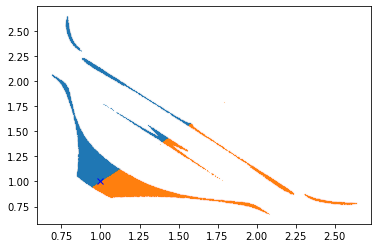

In [90]:
def binData(tags, data, ref_bins):
    for tag in tags:
        m12 = data[tag]["sig_m12"]
        m13 = data[tag]["sig_m13"]
        if tag=="Kspipi":
            m12_tag = data[tag]["tag_m12"]
            m13_tag = data[tag]["tag_m13"]
            bins = []
            for i in range(len(m12)):
                _bin = getBin(m12[i], m13[i], ref_bins)
                bins.append(_bin)
            data[tag].insert(len(data[tag].keys()), "bin_sig", bins, True)
            tag_bins = []
            for i in range(len(m12_tag)):
                _bin = getBin(m12_tag[i], m13_tag[i], ref_bins)
                print(f"At {i}% binning")
                tag_bins.append(_bin)
            data[tag].insert(len(data[tag].keys()), "bin_tag", tag_bins, True)

        
        else : 
            bins = []
            for i in range(len(m12)):
                _bin = getBin(m12[i], m13[i], ref_bins)
                print(f"At {i}% binning")
                bins.append(_bin)
            
            data[tag].insert(0, "bin", bins, True)


    return data

#print(ref_bins)
#print(data)
b = getBin(1,1,ref_bins)
print(b)
f,a=plt.subplots(1,1)
a.plot(1,1,marker="x",color="blue")
df_Bin_plus = equalBinning(refDD, abs(b), 1)
df_Bin_minus = equalBinning(refDD, 9-abs(b), -1)
xp, yp, ddp, Fpp, Fmp = df_Bin_plus.T.values
xm, ym, ddm, Fpm, Fmm = df_Bin_minus.T.values
a.scatter(xp,yp, s=0.01, marker="x")
a.scatter(xm,ym, s=0.01, marker="x")
print(b)

#binned_Data = binData(list(data.keys()), data, ref_bins)

If you run this code (uncomment the last line), you will find that it takes quite a long time. Fortunately, I've already binned this data and saved it into a `pickle` file so we can just load that instead.


In [91]:
binned_data = {}
for tag in data:
    binned_data[tag] = pd.read_pickle(f"{tag}_data.pkl")
print(binned_data)
#for tag in binned_Data:
#    df = binned_Data[tag]
#    df.to_pickle(f"{tag}_data.pkl")


{'KK':       bin   sig_m12   sig_m13
0      -1  2.528499  0.705363
1       1  0.780972  1.276463
2      -2  1.127792  0.809603
3       2  0.644745  2.731115
4       1  0.760000  2.264633
...   ...       ...       ...
2523   -7  2.732898  0.861259
2524   -8  2.755401  0.821125
2525   -1  2.504515  0.710276
2526   -1  2.691892  0.781867
2527    4  0.869915  1.092934

[2528 rows x 3 columns], 'Kspi0':       bin   sig_m12   sig_m13
0      -5  1.236443  1.049986
1      -4  1.048282  0.877797
2       1  0.780972  1.276463
3       8  0.802127  2.762997
4      -2  1.127792  0.809603
...   ...       ...       ...
1720    2  0.693501  2.874300
1721   -2  2.420555  0.771884
1722   -2  1.852176  0.750892
1723    4  0.913453  1.067202
1724    4  0.983332  1.006369

[1725 rows x 3 columns], 'Kppim':        bin   sig_m12   sig_m13
0        1  0.780972  1.276463
1        8  0.802127  2.762997
2        2  0.644745  2.731115
3        1  0.760000  2.264633
4        2  0.715103  2.826325
...    ...       

Now we can easily get the individual yields, $N_i$, per bin for each type of $D^0 \to K_S^0 \pi^+ \pi^-$ decay we have. All we need to do is count all of the entries with the bin $i$. In the case of $D \to K_S^0 \pi^+ \pi^-$ v.s. $D^0 \to K_S^0 \pi^+ \pi^-$ we just measure the number of events on "signal" side bin $i$ and "tag" side $j$.

{'KK': {'1': 1047, '2': 533, '3': 144, '4': 81, '5': 32, '6': 33, '7': 345, '8': 313}, 'Kspi0': {'1': 344, '2': 452, '3': 184, '4': 253, '5': 84, '6': 44, '7': 254, '8': 110}, 'Kppim': {'1': 6219, '-1': 1298, '2': 5069, '-2': 312, '3': 1763, '-3': 61, '4': 1630, '-4': 193, '5': 576, '-5': 71, '6': 386, '-6': 33, '7': 3068, '-7': 234, '8': 1939, '-8': 605}, 'Bp2Dhp': {'1': 601, '2': 435, '3': 144, '4': 167, '5': 73, '6': 29, '7': 254, '8': 197}, 'Bm2Dhm': {'1': 616, '2': 452, '3': 146, '4': 134, '5': 41, '6': 29, '7': 237, '8': 245}}
1047
1047
133
133
133
133
134
134
134
134


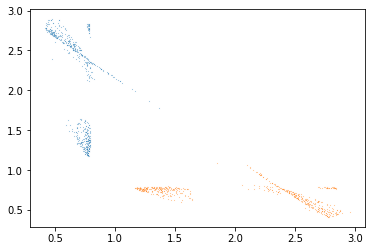

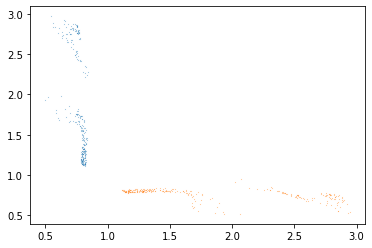

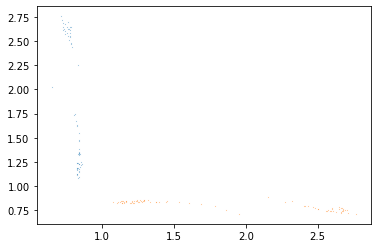

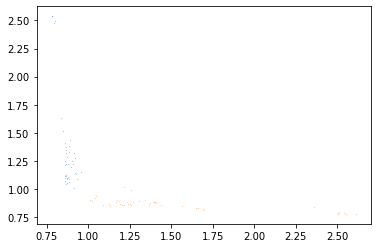

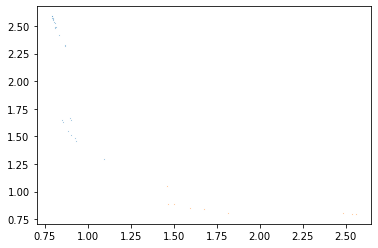

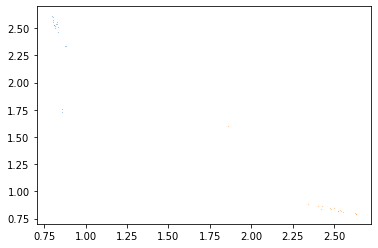

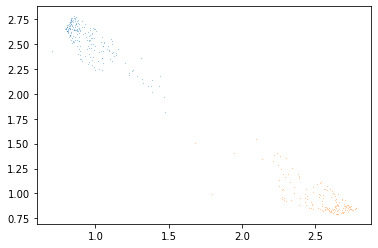

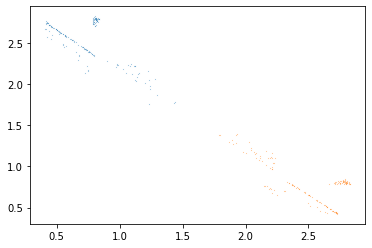

In [92]:
def getNi(tag, i, data):
    df = data[tag]
    
    if tag == "Kppim":
        cond = df["bin"]==i
        return len(df[ cond ])
    
    elif tag=="KK" or tag=="Kspi0" or tag=="Bp2Dhp" or tag=="Bm2Dhm":

        condp = df["bin"]==i
        condm = df["bin"]==-i
        
        Np = len(df[ condp ])
        Nm = len(df[ condm ])
        N = Np + Nm
        return N



def getMij(i, j, data):
    df = data["Kspipi"]
    cond_sig = df["bin_sig"]==i
    cond_tag = df["bin_tag"]==j
    
    Npp = len(df[cond_sig & cond_tag])
    
    cond_sigm = df["bin_sig"]==-i
    cond_tagp = df["bin_tag"]==j
    
    Nmp = len(df[cond_sigm & cond_tagp])
    
    cond_sigp = df["bin_sig"]==i
    cond_tagm = df["bin_tag"]==-j
    
    Npm = len(df[cond_sigp & cond_tagm])
    
    cond_sigm = df["bin_sig"]==-i
    cond_tagm = df["bin_tag"]==-j
    
    Nmm = len(df[cond_sigm & cond_tagm])
    
    N = Npp + Nmp + Npm + Nmm
    
    
    return N



N = {}
for tag in "KK Kspi0 Kppim Bp2Dhp Bm2Dhm".split():
    N_tag = {}
    for i in range(1,9):
        N_tag[f"{i}"]  = getNi(tag, i, binned_data)
        if tag=="Kppim":
            N_tag[f"{-i}"] = getNi(tag, -i, binned_data) 
    N[tag] = N_tag
    




    
M = {}

for i in range(1,9):
    for j in range(1,9):
        M[f"{i}{j}"] = getMij(i, j, binned_data) 
        M[f"{-i}{j}"] = getMij(-i, j, binned_data)
        M[f"{i}{-j}"] = getMij(i, -j, binned_data)
        M[f"{-i}{-j}"] = getMij(-i, -j, binned_data)

        
for i in range(1,9):
    df = binned_data["KK"]
    condP = df["bin"]==i
    condM = df["bin"]==-i
    dfP = df[condP]
    dfM = df[condM]
    xP = dfP["sig_m12"]
    yP = dfP["sig_m13"]
    xM = dfM["sig_m12"]
    yM = dfM["sig_m13"]
    f,a=plt.subplots(1,1)
    a.scatter(xP,yP, s=0.01, marker="x")
    a.scatter(xM,yM, s=0.01, marker="x")
    
print(N)
print(getNi("KK", 1, binned_data))
print(getNi("KK", -1, binned_data))
print(M["12"])
print(M["1-2"])
print(M["-12"])
print(M["-1-2"])


print(M["21"])
print(M["2-1"])
print(M["-21"])
print(M["-2-1"])


Let's consider the $\psi(3770)$ amplitude and its squared magnitude ($\propto$ probability)
\begin{equation}
\psi = AB - CD 
\end{equation}
\begin{equation}
|\psi|^2 = |A|^2 |B|^2 + |C|^2 |D|^2 - 2 |A||B||C||D| \cos(\Delta\delta_{AC} - \Delta\delta_{BD})
\end{equation}

So for each pair of bins we have
\begin{equation}
|\psi|_{ij}^2 = |A|^2_i |B|^2_j + |C|^2_i |D|^2_j - 2 |A|_i|B|_j|C|_i|D|_j (c_i^{AC} c_j^{BD} + s_i^{AC} s_j^{BD})
\end{equation}

We can identify each of the magnitudes with the fractions $F_{\pm i}$ for $D^0 (+i)$ and $\bar{D}^0 (-i)$ instead
\begin{equation}
|\psi|_{ij}^2 =  k (F_{i} F_{-j} + F_{-i} F_{j} - 2 \sqrt{ F_{i} F_{-i} F_{j} F_{-j} } (c_i^{AC} c_j^{BD} + s_i^{AC} s_j^{BD}))
\end{equation}

In the case where we aren't interested in the bin pair (i.e. we sum over $j$) then we have the expected density $n_i$ for a particular tag of $CP=\pm$ we have
\begin{equation}
n_i = k (F_{i} F_{-j} + F_{-i} \mp 2 \sqrt{F_{i} F_{-i}} c_i^{AC})
\end{equation}

where we can obtain $k$ by just normalising the $\sum RHS_i = 1$. 
So the expected yield for a particular tag is then

\begin{equation}
\begin{split}
N_i^{\pm} &= k N^{\pm}_\text{total} (F_{i} F_{-j} + F_{-i} \mp 2 \sqrt{F_{i} F_{-i}} c_i^{AC}) \\
          &= N^{\pm}_\text{total} \frac{F_{i} F_{-j} + F_{-i} \mp 2 \sqrt{F_{i} F_{-i}} c_i}{\sum_i F_{i} F_{-j} + F_{-i} \mp 2 \sqrt{F_{i} F_{-i}} c_i}
          \end{split}
\end{equation}



In [93]:
def F(i):
    FSum = 0
    if i>0:
        for j in range(1,9):
            FSum += N["Kppim"][f"{j}"]
        return N["Kppim"][f"{i}"]#/FSum
    if i<0 :
        for j in range(1,9):
            FSum += N["Kppim"][f"{-j}"]   
        return N["Kppim"][f"{i}"]#/FSum

    
def trueF(i):
    if i>0:
        return Fpi[f"{i}"]
        #return F(i)
    elif i<0:
        return Fmi[f"{-i}"]
        #return F(i)

    
print(len(binned_data["Kppim"]))
    
print(F(-1))
print(N["Kppim"])
for i in range(1,9):
    print(f"{i}\t{round(F(i),3)}\t{round(F(-i),3)}")

print(f"i\tF_iMeas\tF_iTrue\tdF_i\tF_-iMeas\tF_-iTrue\tdF_-i")
for key in Fpi:
    dFpi = F(int(key)) - Fpi[key]
    dFmi = F(-int(key)) - Fmi[key]
    print(f"{key}\t{round(F(int(key)),3)}\t{round(trueF(int(key)),3)}\t{round(dFpi,3)}\t{round(F(-int(key)),3)}\t{round(trueF(-int(key)),3)}\t{round(dFmi,3)}")
    

23457
1298
{'1': 6219, '-1': 1298, '2': 5069, '-2': 312, '3': 1763, '-3': 61, '4': 1630, '-4': 193, '5': 576, '-5': 71, '6': 386, '-6': 33, '7': 3068, '-7': 234, '8': 1939, '-8': 605}
1	6219	1298
2	5069	312
3	1763	61
4	1630	193
5	576	71
6	386	33
7	3068	234
8	1939	605
i	F_iMeas	F_iTrue	dF_i	F_-iMeas	F_-iTrue	dF_-i
1	6219	3.133	6215.867	1298	3.176	1294.824
2	5069	3.196	5065.804	312	3.164	308.836
3	1763	0.774	1762.226	61	0.789	60.211
4	1630	0.338	1629.662	193	0.331	192.669
5	576	0.088	575.912	71	0.086	70.914
6	386	0.138	385.862	33	0.15	32.85
7	3068	0.947	3067.053	234	0.968	233.032
8	1939	1.561	1937.439	605	1.512	603.488


In [94]:
def eCP(i, c, CP, useTrue=True):
    h=1
    if CP==1:
        h=0.0577
    elif CP==-1:
        h = 0.0297
    if useTrue:
        eCPSum=0
        for j in range(1,9):
            eCPSum+=h*(trueF(j) + trueF(-j) - 2*CP*c[f"{j}"]*(trueF(j)*trueF(-j))**0.5)
        return h*(trueF(i) + trueF(-i) - 2*CP*c[f"{i}"]*(trueF(i)*trueF(-i))**0.5)#/eCPSum
    else:
        eCPSum=0
        for j in range(1,9):
            eCPSum+=h*(F(j) + F(-j) - 2*CP*c[f"{j}"]*(F(j)*F(-j))**0.5)
        return h*(F(i) + F(-i) - 2*CP*c[f"{i}"]*(F(i)*F(-i))**0.5)#/eCPSum

To fit for $c_i$ with the $CP^\pm$ tag, we fit a Poisson distribution $P(x |\mu)$ with the expected yield as $\mu$ and the real yield as $x$.

1	1.6659335658290872
2	2.391840296175439
3	1.1075674736459205
4	0.062116722627379335
5	0.054066864712155105
6	0.7508173665546605
7	1.2019738829394082
8	2.7272610381231197


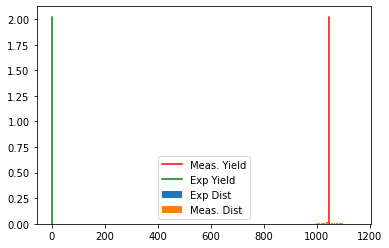

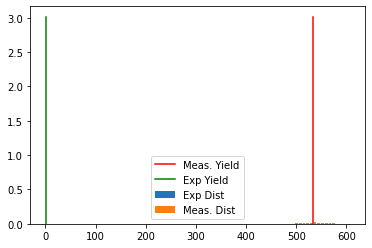

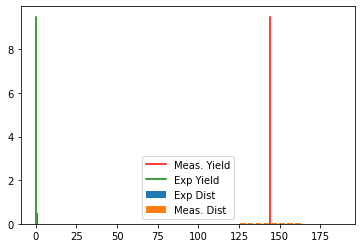

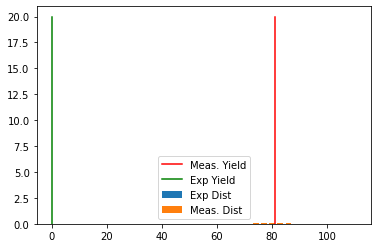

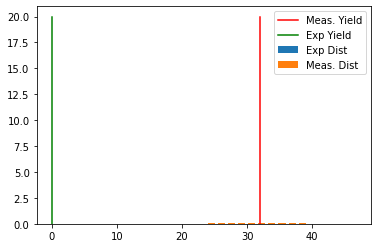

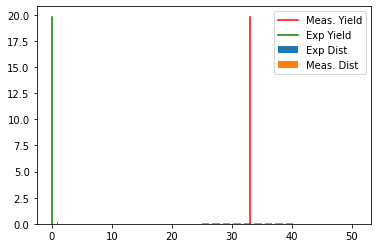

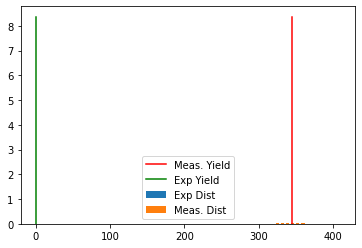

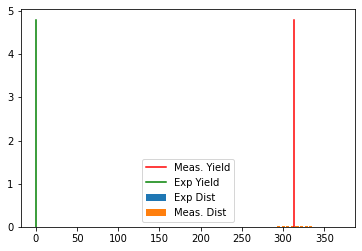

In [95]:
KK_Sum = 0
Kspi0_Sum = 0
for i in range(1,9):
    KK_Sum += N["KK"][f"{i}"]#+N["KK"][f"{-i}"]
    Kspi0_Sum += N["Kspi0"][f"{i}"]#+N["KK"][f"{-i}"]


for i in range(1,9):
    mu = eCP(i, ci, 1)
    
    f, a = plt.subplots(1,1)
    x = np.random.poisson(mu, 1000)
    n, b = np.histogram(x, bins=20, density=True)
    c = 0.5*(b[1:] + b[:-1])
    w = 0.7*(c[1] - c[0])
    xm = N["KK"][f"{i}"]#+N["KK"][f"{-i}"]
    ym = max(n)
    
    x0 = np.random.poisson(xm, 1000)
    n0, b0 = np.histogram(x0, bins=20, density=True)
    c0 = 0.5*(b0[1:] + b0[:-1])
    w0 = 0.7*(c0[1] - c0[0])
    
    
    a.bar(c, n, width=w, label=f"Exp Dist")
    a.bar(c0, n0, width=w0, label=f"Meas. Dist")
    a.plot([xm,xm], [0,ym], color="red", label="Meas. Yield")
    a.plot([mu,mu], [0,ym], color="green", label="Exp Yield")
    a.legend()
    
    
    
hp = {}
hm = {}

for i in range(1,9):
    hpi = eCP(i,ci,1)*KK_Sum/N["KK"][f"{i}"]
    print(f"{i}\t{hpi}")

    
    
    
    

<ipython-input-96-abc88c619c45>:20: InitialParamWarning: Parameter c1 does not have neither initial value nor limits.
  mCP = iminuit.Minuit(nllCP)
<ipython-input-96-abc88c619c45>:20: InitialParamWarning: Parameter c2 does not have neither initial value nor limits.
  mCP = iminuit.Minuit(nllCP)
<ipython-input-96-abc88c619c45>:20: InitialParamWarning: Parameter c3 does not have neither initial value nor limits.
  mCP = iminuit.Minuit(nllCP)
<ipython-input-96-abc88c619c45>:20: InitialParamWarning: Parameter c4 does not have neither initial value nor limits.
  mCP = iminuit.Minuit(nllCP)
<ipython-input-96-abc88c619c45>:20: InitialParamWarning: Parameter c5 does not have neither initial value nor limits.
  mCP = iminuit.Minuit(nllCP)
<ipython-input-96-abc88c619c45>:20: InitialParamWarning: Parameter c6 does not have neither initial value nor limits.
  mCP = iminuit.Minuit(nllCP)
<ipython-input-96-abc88c619c45>:20: InitialParamWarning: Parameter c7 does not have neither initial value nor li

------------------------------------------------------------------
| FCN = 5.829e+04               |     Ncalls=123 (123 total)     |
| EDM = 3.48e-06 (Goal: 0.0002) |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------
| FCN = 5.829e+04               |     Ncalls=123 (123 total)     |
| EDM = 3.48e-06 (Goal: 0.0002) |            up = 1.0         

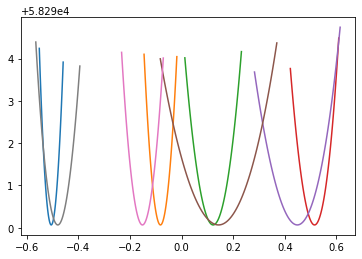

In [96]:
def nllCP(c1,c2,c3,c4,c5,c6,c7,c8):
    c = {"1":c1,
        "2":c2,
        "3":c3,
        "4":c4,
        "5":c5,
        "6":c6,
        "7":c7,
        "8":c8,}
    nll = 0
    for i in range(1,9):
        xPlus = N["KK"][f"{i}"]# + N["KK"][f"{-i}"]
        muPlus = eCP(i, c, 1)
        xMinus = N["Kspi0"][f"{i}"]# + N["Kspi0"][f"{-i}"]
        muMinus = eCP(i, c, -1)
        nll += -2 * scipy.stats.poisson(muPlus).logpmf(xPlus)
        nll += -2 * scipy.stats.poisson(muMinus).logpmf(xMinus)
    return nll

mCP = iminuit.Minuit(nllCP)
mCP.print_level=3
resCP = mCP.migrad()
print(resCP)
#resMinosCP = mCP.minos()
for param in mCP.params:
    x,y=mCP.profile(param.name)
    plt.plot(x,y)

-0.505+-0.023	-0.895	16.856
-0.082+-0.032	-0.374	9.201
0.122+-0.055	0.301	-3.257
0.515+-0.047	0.948	-9.241
0.448+-0.083	0.932	-5.825
0.143+-0.113	0.411	-2.37
-0.152+-0.04	-0.485	8.247
-0.48+-0.043	-0.904	9.95
{'1': -0.8953307358368907, '2': -0.3742523393240013, '3': 0.30058859433636675, '4': 0.9484870400765844, '5': 0.9317279163728642, '6': 0.4105983664259624, '7': -0.4849299380759217, '8': -0.9043300436820767}
{'1': -0.5052755494472865, '2': -0.08205357196155891, '3': 0.12208936851381004, '4': 0.5150479493186148, '5': 0.4483249756746688, '6': 0.14309453011574194, '7': -0.15183893079371688, '8': -0.4797601844571769}
{'1': 16.85591480526997, '2': 9.201379582203439, '3': -3.2570644500140387, '4': -9.24145930434422, '5': -5.824819543139848, '6': -2.3695962398888906, '7': 8.247289193408516, '8': 9.949579979062017}


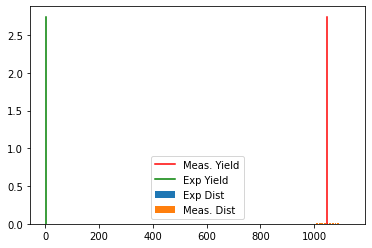

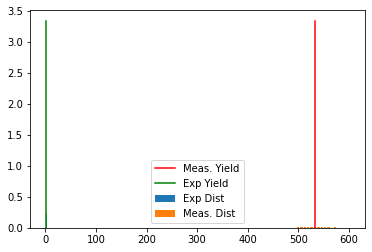

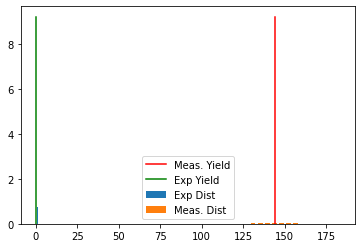

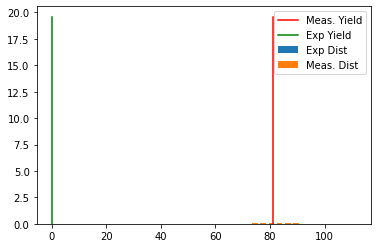

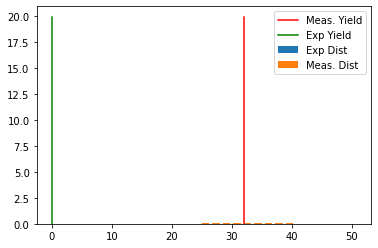

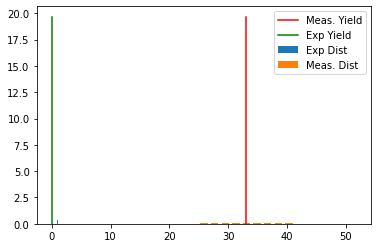

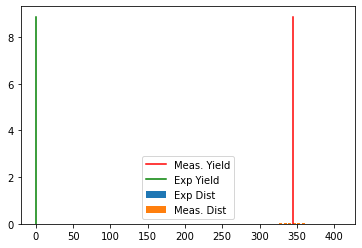

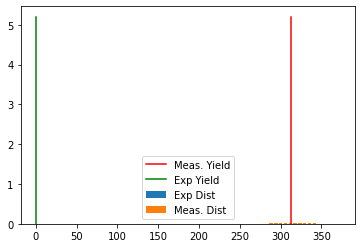

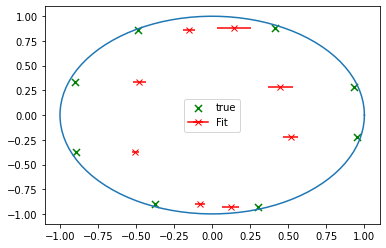

In [97]:
cs = mCP.params
cFit = {}
ecFit = {}
for _c in cs:
    name = _c.name.split('c')[-1]
    value = _c.value
    err = _c.error
    cFit[name] = value
    ecFit[name] = err
    
pullC = {}
for key in cFit:
    pull = (cFit[key] - ci[key])/ecFit[key]
    pullC[key] = pull
    
    print(f"{round(cFit[key], 3)}+-{round(ecFit[key],3)}\t{round(cTrue[key],3)}\t{round(pull,3)}")

print(ci)
print(cFit)
print(pullC)


for i in range(1,9):
    muPlus = eCP(i, cFit, 1)
    muMinus = eCP(i, cFit, 1)
    
    f, a = plt.subplots(1,1)
    xPlus = np.random.poisson(muPlus, 1000)
    nPlus, bPlus = np.histogram(xPlus, bins=20, density=True)
    cPlus = 0.5*(bPlus[1:] + bPlus[:-1])
    wPlus = 0.7*(cPlus[1] - cPlus[0])
    xmPlus = N["KK"][f"{i}"]#+N["KK"][f"{-i}"]
    ymPlus = max(nPlus)
    
    x0Plus = np.random.poisson(xmPlus, 1000)
    n0Plus, b0Plus = np.histogram(x0Plus, bins=20, density=True)
    c0Plus = 0.5*(b0Plus[1:] + b0Plus[:-1])
    w0Plus = 0.7*(c0Plus[1] - c0Plus[0])
    
    
    a.bar(cPlus, nPlus, width=wPlus, label=f"Exp Dist")
    a.bar(c0Plus, n0Plus, width=w0Plus, label=f"Meas. Dist")
    a.plot([xmPlus,xmPlus], [0,ymPlus], color="red", label="Meas. Yield")
    a.plot([muPlus,muPlus], [0,ymPlus], color="green", label="Exp Yield")
    a.legend()
    
    
f2,a2=plt.subplots(1,1)
th=np.linspace(0,2*np.pi,100)
_X = np.cos(th)
_Y = np.sin(th)
a2.plot(_X,_Y)
for key in cFit:
    a2.errorbar(cFit[key],si[key],xerr=ecFit[key],marker="x",color="red",label="Fit")
    a2.scatter(ci[key],si[key],marker="x",s=50,color="green", label="true")
a2.legend()

handles, labels = a2.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
a2.legend(by_label.values(), by_label.keys())


In [98]:
def eDT(i,j,c,s, useTrue=True):
    eDTSum=0
    ci= c[f"{i}"] 
    cj = c[f"{j}"] 
    si= s[f"{i}"]
    sj = s[f"{j}"] 
    h = 1.718e-7
    for k in range(1,9):
        for l in range(1,9):
            ck= c[f"{k}"] 
            cl = c[f"{l}"] 
            sk= s[f"{k}"]
            sl = s[f"{l}"] 
            if useTrue:
                eDTSum+=0.5*(trueF(k)*trueF(-l) + trueF(-k)*trueF(l) - 2*(ck*cl + sk*sl )*(trueF(k)*trueF(-k)*trueF(l)*trueF(-l))**0.5)
            else:
                eDTSum+=0.5*(F(k)*F(-l) + F(-k)*F(l) - 2*(ck*cl + sk*sl )*(F(k)*F(-k)*F(l)*F(-l))**0.5)
                
    if useTrue:
        return (trueF(i)*trueF(-j) + trueF(-i)*trueF(j) - 2*(ci*cj + si*sj )*(trueF(i)*trueF(-i)*trueF(j)*trueF(-j))**0.5)/(2*eDTSum)
    else:
        return (F(i)*F(-j) + F(-i)*F(j) - 2*(ci*cj + si*sj )*(F(i)*F(-i)*F(j)*F(-j))**0.5)/(2*eDTSum)

DT_Sum = 0
for i in range(1,9):
    for j in range(1,9):
        DT_Sum+=M[f"{i}{j}"]# + M[f"{-i}{-j}"]

                



sum_Dppij = 0
sum_Eppij = 0
sum_Eppji = 0
sum_D = 0
sum_E = 0

print(DT_Sum)
            
print(f"ij\tD_ij\tE_ij\tE_ji")
for i in range(1,9):
    for j in range(1,9):
        D_ppij = round( M[f"{i}{j}"]*100/DT_Sum,3)
        D_pmij = round(M[f"{i}{-j}"]*100/DT_Sum,3)
        D_mpij = round(M[f"{-i}{j}"]*100/DT_Sum,3)
        D_mmij = round(M[f"{-i}{-j}"]*100/DT_Sum,3)
        D = round(D_ppij,3)
        
        sum_Dppij += D_ppij
        E_ppij = round(eDT(i,j,ci,si, useTrue=True),3)
        
        E_ppji = round(eDT(j,i,ci,si),3)
        ET = E_ppijT
        EF = E_ppijF
        
        sum_Eppij += E_ppij
        sum_Eppji += E_ppji
        
        sum_D += D
        sum_E += EF
        
        print(f"{i}{j}\t{D_ppij}\t{E_ppij}\t{E_ppji}\t{D}\t{ET}\t{EF}")
        

print(f"\t{round(sum_Dppij,3)}\t{round(sum_Eppij,3)}\t{round(sum_Eppji,3)}")
        
    

1833
ij	D_ij	E_ij	E_ji
11	7.965	0.009	0.009	7.965	0.159	0.159
12	7.256	0.05	0.05	7.256	0.159	0.159
13	2.891	0.035	0.035	2.891	0.159	0.159
14	3.546	0.028	0.028	3.546	0.159	0.159
15	0.873	0.008	0.008	0.873	0.159	0.159
16	0.655	0.012	0.012	0.655	0.159	0.159
17	4.801	0.041	0.041	4.801	0.159	0.159
18	2.619	0.023	0.023	2.619	0.159	0.159
21	7.31	0.05	0.05	7.31	0.159	0.159
22	4.746	0.008	0.008	4.746	0.159	0.159
23	1.8	0.011	0.011	1.8	0.159	0.159
24	2.51	0.019	0.019	2.51	0.159	0.159
25	0.764	0.007	0.007	0.764	0.159	0.159
26	0.6	0.014	0.014	0.6	0.159	0.159
27	3.164	0.074	0.074	3.164	0.159	0.159
28	2.51	0.072	0.072	2.51	0.159	0.159
31	1.855	0.035	0.035	1.855	0.159	0.159
32	2.019	0.011	0.011	2.019	0.159	0.159
33	0.873	0.0	0.0	0.873	0.159	0.159
34	0.873	0.002	0.002	0.873	0.159	0.159
35	0.327	0.001	0.001	0.327	0.159	0.159
36	0.109	0.003	0.003	0.109	0.159	0.159
37	1.528	0.022	0.022	1.528	0.159	0.159
38	1.037	0.029	0.029	1.037	0.159	0.159
41	3.001	0.028	0.028	3.001	0.159	0.159
42	1.8	0.019	0.019	1.8	0

<ipython-input-99-226b8cae16d7>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, a = plt.subplots(1,1)


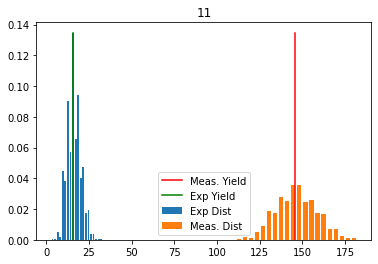

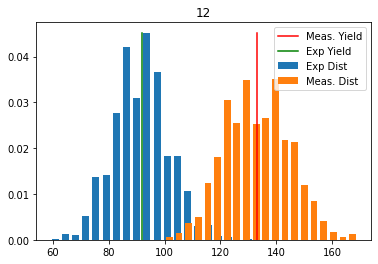

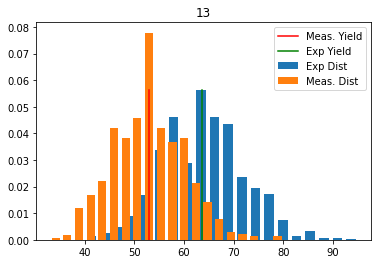

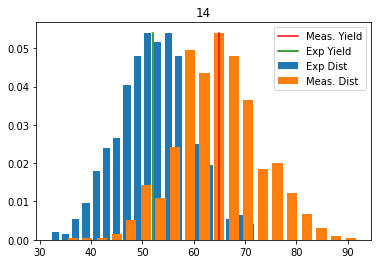

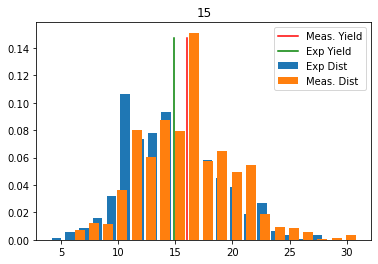

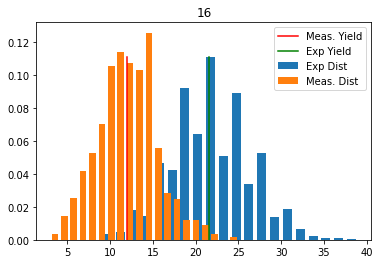

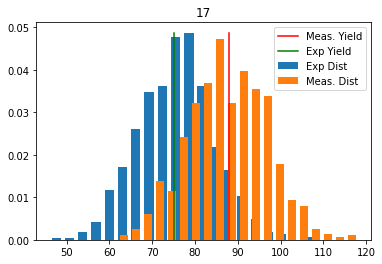

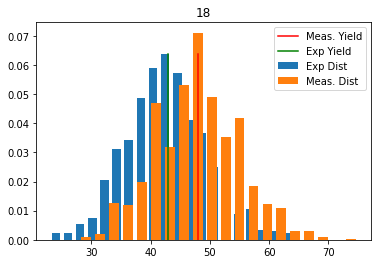

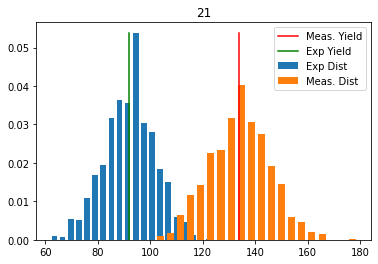

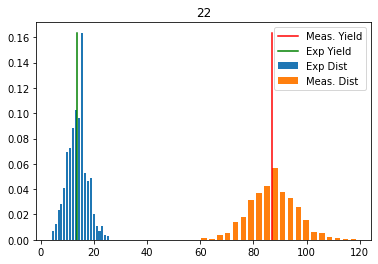

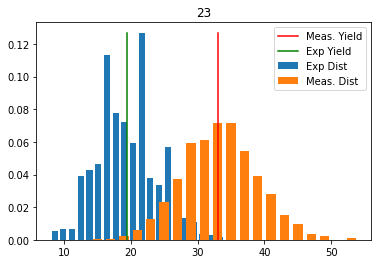

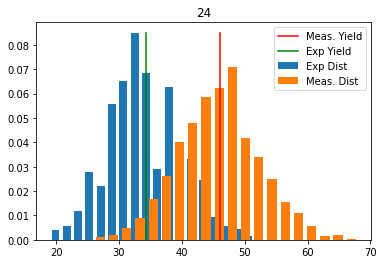

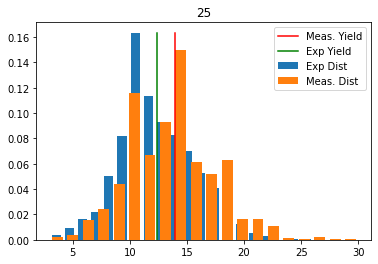

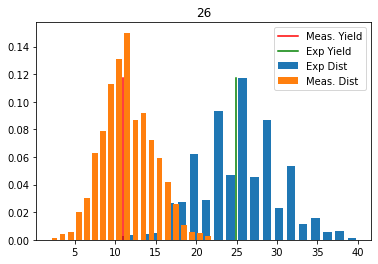

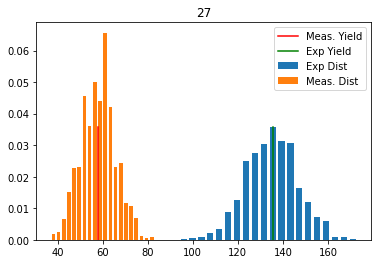

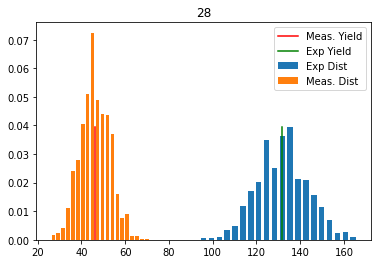

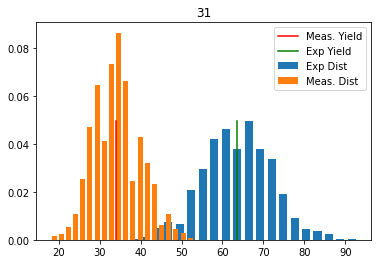

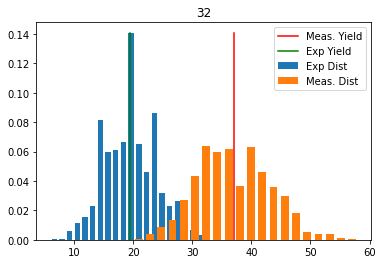

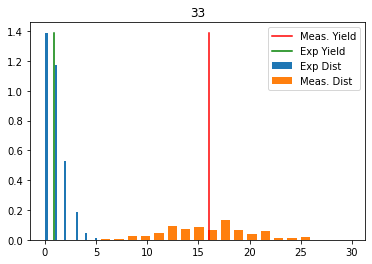

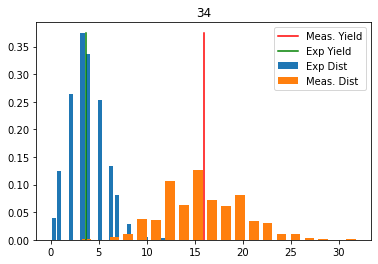

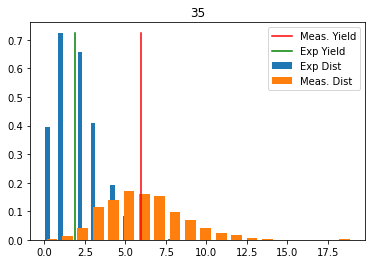

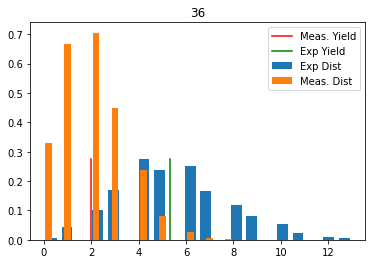

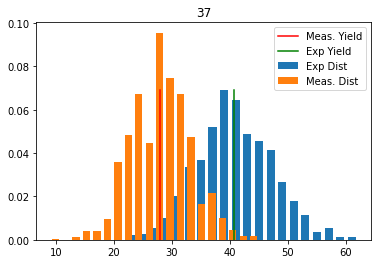

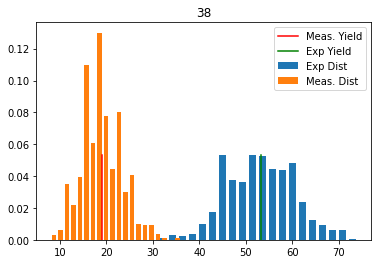

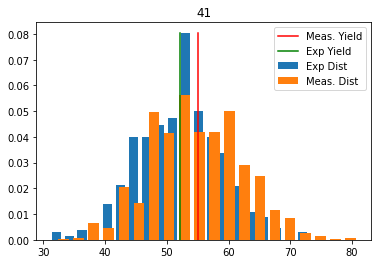

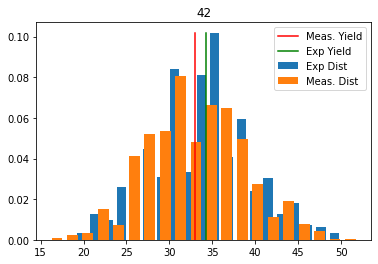

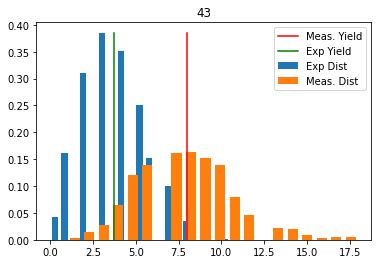

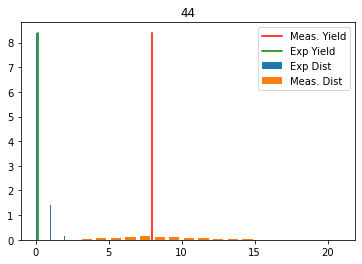

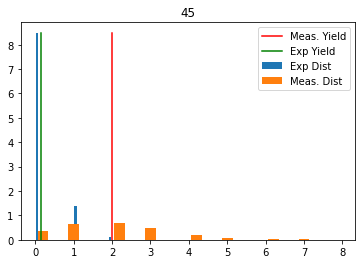

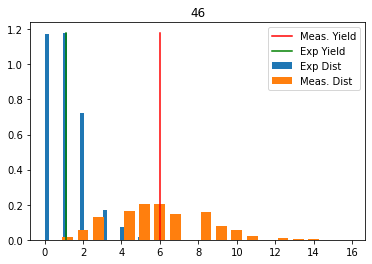

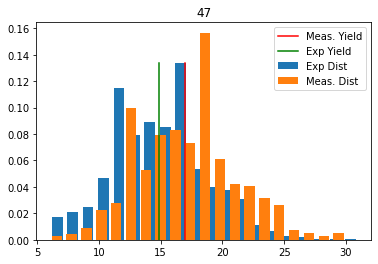

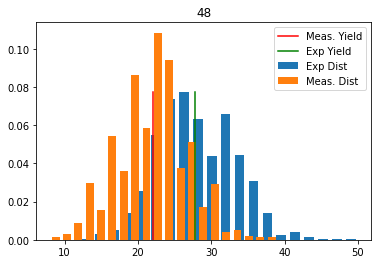

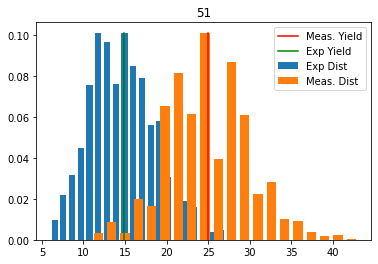

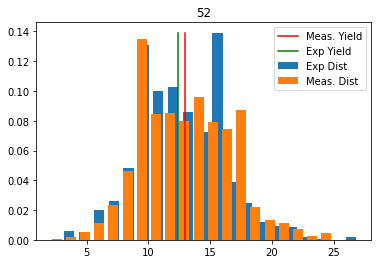

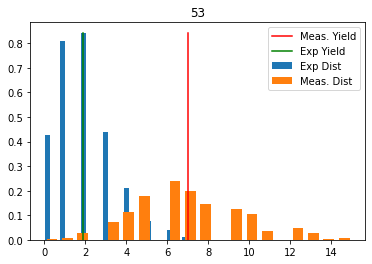

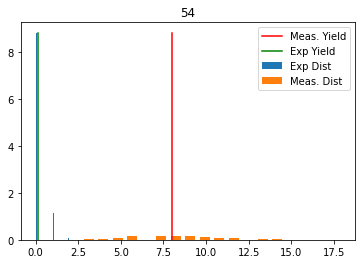

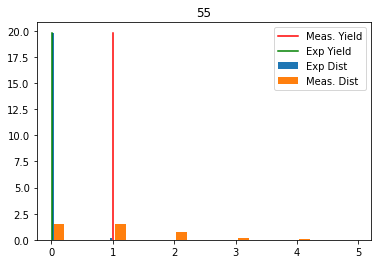

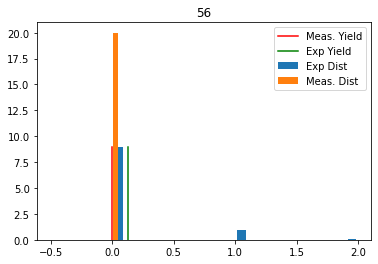

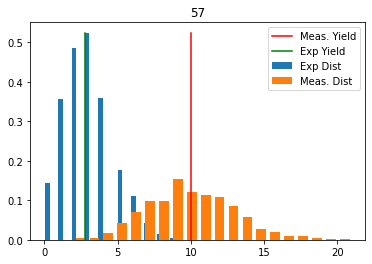

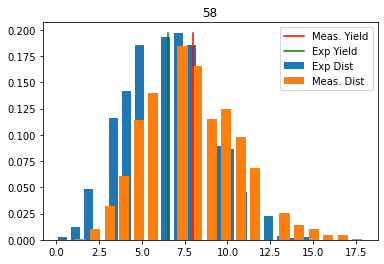

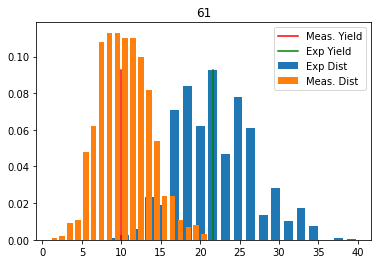

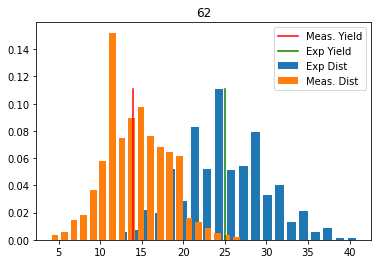

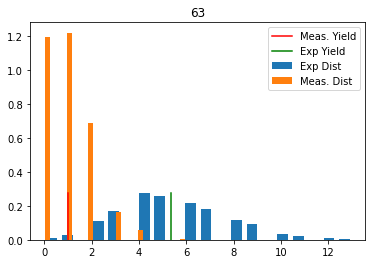

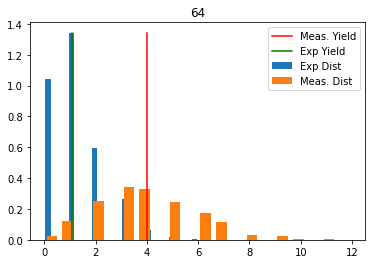

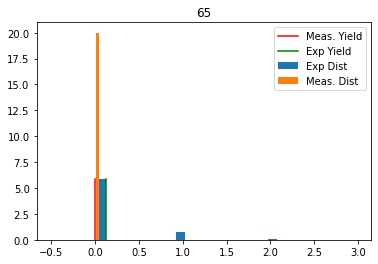

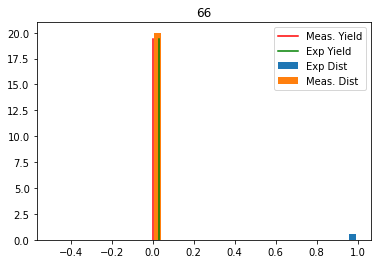

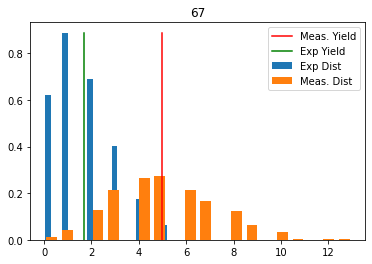

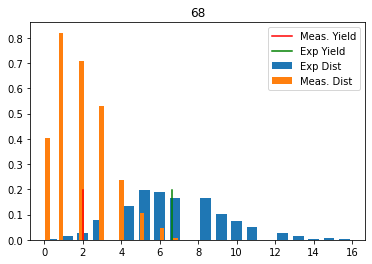

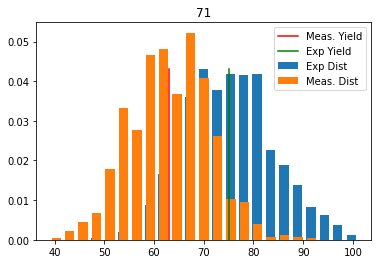

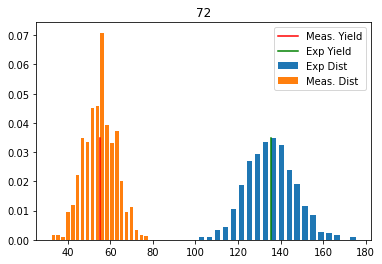

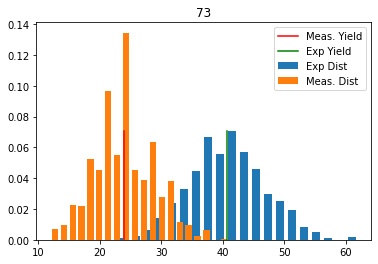

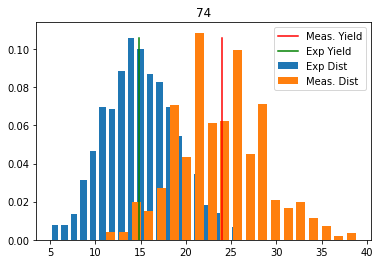

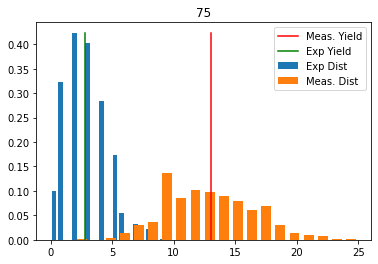

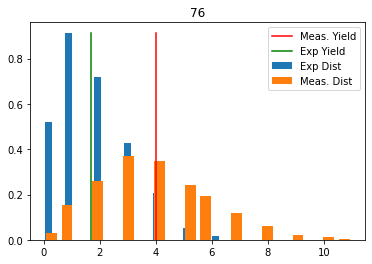

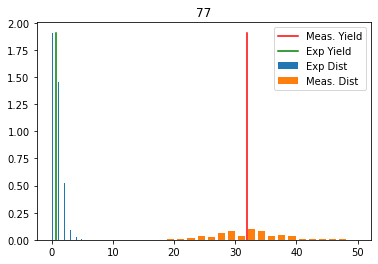

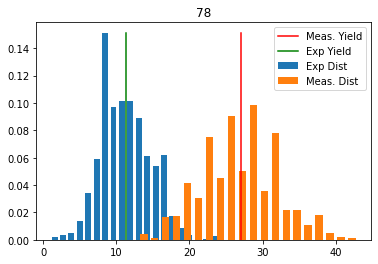

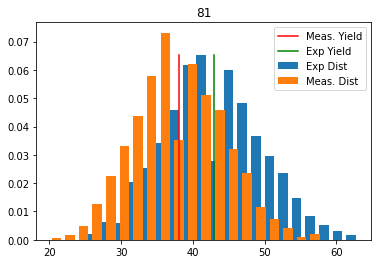

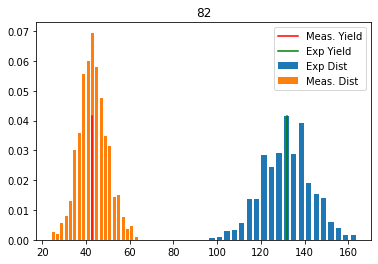

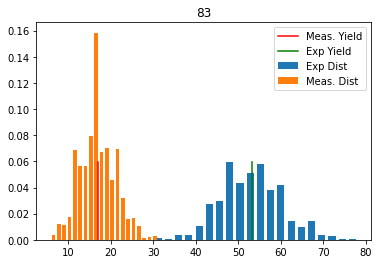

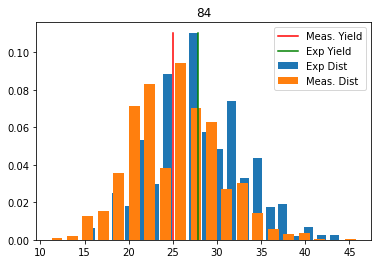

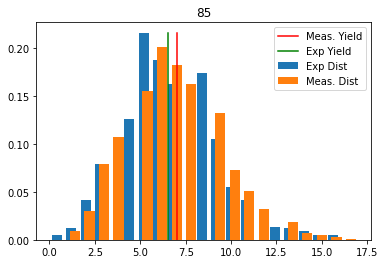

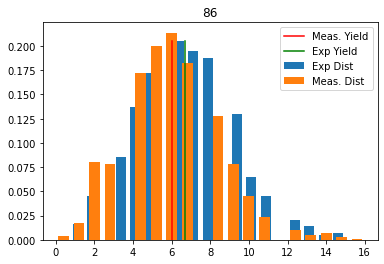

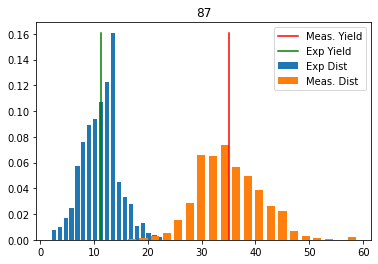

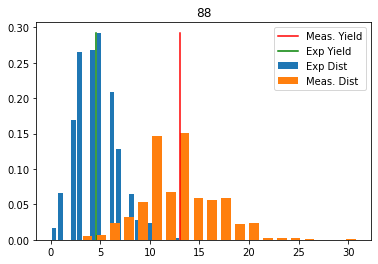

In [99]:

for i in range(1,9):
    for j in range(1,9):


        mu = eDT(i,j, ci, si, useTrue=True)*DT_Sum

        f, a = plt.subplots(1,1)
        x = np.random.poisson(mu, 1000)
        n, b = np.histogram(x, bins=20, density=True)
        c = 0.5*(b[1:] + b[:-1])
        w = 0.7*(c[1] - c[0])
        xm = M[f"{i}{j}"]
        

        ym = max(n)

        x0 = np.random.poisson(xm, 1000)
        n0, b0 = np.histogram(x0, bins=20, density=True)
        c0 = 0.5*(b0[1:] + b0[:-1])
        w0 = 0.7*(c0[1] - c0[0])


        a.bar(c, n, width=w, label=f"Exp Dist")
        a.bar(c0, n0, width=w0, label=f"Meas. Dist")
        a.plot([xm,xm], [0,ym], color="red", label="Meas. Yield")
        a.plot([mu,mu], [0,ym], color="green", label="Exp Yield")
        a.set_title(f"{i}{j}")
        a.legend()



In [100]:
def nllDT(c1,c2,c3,c4,c5,c6,c7,c8, s1,s2,s3,s4,s5,s6,s7,s8):
    c = {"1":c1,
        "2":c2,
        "3":c3,
        "4":c4,
        "5":c5,
        "6":c6,
        "7":c7,
        "8":c8}
    s = {"1":s1,
        "2":s2,
        "3":s3,
        "4":s4,
        "5":s5,
        "6":s6,
        "7":s7,
        "8":s8}
    nll = 0
    for i in range(1,9):
        for j in range(1,9):
            mu = eDT(i,j, c, s,useTrue=True)*DT_Sum
            x = M[f"{i}{j}"]
            nll += -2 * scipy.stats.poisson(mu).logpmf(x)
        #nll += -2 * scipy.stats.poisson(muMinus).logpmf(xMinus)
    return nll



def nll(c1,c2,c3,c4,c5,c6,c7,c8, s1,s2,s3,s4,s5,s6,s7,s8):
    return  nllDT(c1,c2,c3,c4,c5,c6,c7,c8,s1,s2,s3,s4,s5,s6,s7,s8) +  nllCP(c1,c2,c3,c4,c5,c6,c7,c8)


m = iminuit.Minuit(nll)
m.print_level=3
r = m.migrad()
print(r)


<ipython-input-100-ad0a7ee61737>:33: InitialParamWarning: Parameter c1 does not have neither initial value nor limits.
  m = iminuit.Minuit(nll)
<ipython-input-100-ad0a7ee61737>:33: InitialParamWarning: Parameter c2 does not have neither initial value nor limits.
  m = iminuit.Minuit(nll)
<ipython-input-100-ad0a7ee61737>:33: InitialParamWarning: Parameter c3 does not have neither initial value nor limits.
  m = iminuit.Minuit(nll)
<ipython-input-100-ad0a7ee61737>:33: InitialParamWarning: Parameter c4 does not have neither initial value nor limits.
  m = iminuit.Minuit(nll)
<ipython-input-100-ad0a7ee61737>:33: InitialParamWarning: Parameter c5 does not have neither initial value nor limits.
  m = iminuit.Minuit(nll)
<ipython-input-100-ad0a7ee61737>:33: InitialParamWarning: Parameter c6 does not have neither initial value nor limits.
  m = iminuit.Minuit(nll)
<ipython-input-100-ad0a7ee61737>:33: InitialParamWarning: Parameter c7 does not have neither initial value nor limits.
  m = iminu

------------------------------------------------------------------
| FCN = 5.965e+04               |     Ncalls=444 (455 total)     |
| EDM = 1.1e+05 (Goal: 0.0002)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     False     |     True      |   True    |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   False   |   False   |  True  |
------------------------------------------------------------------
------------------------------------------------------------------
| FCN = 5.965e+04               |     Ncalls=444 (455 total)     |
| EDM = 1.1e+05 (Goal: 0.0002)  |            up = 1.0         

In [101]:

params = m.params
cFit = {}
sFit = {}

for i in range(len(params)):
    if i<8:
        cFit[f"{i+1}"] = params[i]
    else : 
        sFit[f"{i-7}"] = params[i]


a = [cFit[key].value for key in cFit]
b = [sFit[key].value for key in sFit]
c1,c2,c3,c4,c5,c6,c7,c8 = a
s1,s2,s3,s4,s5,s6,s7,s8 = b

x = np.linspace(-1,1,100)

nllc1 = [nll(_x,c2,c3,c4,c5,c6,c7,c8,s1,s2,s3,s4,s5,s6,s7,s8) for _x in x]
nllc2 = [nll(c1,_x,c3,c4,c5,c6,c7,c8,s1,s2,s3,s4,s5,s6,s7,s8) for _x in x]
nllc3 = [nll(c1,c2,_x,c4,c5,c6,c7,c8,s1,s2,s3,s4,s5,s6,s7,s8) for _x in x]
nllc4 = [nll(c1,c2,c3,_x,c5,c6,c7,c8,s1,s2,s3,s4,s5,s6,s7,s8) for _x in x]
nllc5 = [nll(c1,c2,c3,c4,_x,c6,c7,c8,s1,s2,s3,s4,s5,s6,s7,s8) for _x in x]
nllc6 = [nll(c1,c2,c3,c4,c5,_x,c7,c8,s1,s2,s3,s4,s5,s6,s7,s8) for _x in x]
nllc7 = [nll(c1,c2,c3,c4,c5,c6,_x,c8,s1,s2,s3,s4,s5,s6,s7,s8) for _x in x]
nllc8 = [nll(c1,c2,c3,c4,c5,c6,c7,_x,s1,s2,s3,s4,s5,s6,s7,s8) for _x in x]

nlls1 = [nll(c1,c2,c3,c4,c5,c6,c7,c8,_x,s2,s3,s4,s5,s6,s7,s8) for _x in x]
nlls2 = [nll(c1,c2,c3,c4,c5,c6,c7,c8,s1,_x,s3,s4,s5,s6,s7,s8) for _x in x]
nlls3 = [nll(c1,c2,c3,c4,c5,c6,c7,c8,s1,s2,_x,s4,s5,s6,s7,s8) for _x in x]
nlls4 = [nll(c1,c2,c3,c4,c5,c6,c7,c8,s1,s2,s3,_x,s5,s6,s7,s8) for _x in x]
nlls5 = [nll(c1,c2,c3,c4,c5,c6,c7,c8,s1,s2,s3,s4,_x,s6,s7,s8) for _x in x]
nlls6 = [nll(c1,c2,c3,c4,c5,c6,c7,c8,s1,s2,s3,s4,s5,_x,s7,s8) for _x in x]
nlls7 = [nll(c1,c2,c3,c4,c5,c6,c7,c8,s1,s2,s3,s4,s5,s6,_x,s8) for _x in x]
nlls8 = [nll(c1,c2,c3,c4,c5,c6,c7,c8,s1,s2,s3,s4,s5,s6,s7,_x) for _x in x]


def plotMin(x,y):
    f,a=plt.subplots(1,1)
    df = pd.DataFrame(y,x)
    xmin = float(df.idxmin())
    ymin = float(df.min())
    a.plot(x,y)
    a.scatter(xmin,ymin, marker="x",color="red")
    return xmin,ymin

#print(a)

    

-0.8585858585858586
59643.385535062924
1	-0.495	-0.895	0.4	-0.677	-0.376	-0.301
2	-0.071	-0.374	0.304	-0.818	-0.901	0.082
3	0.111	0.301	-0.189	-0.535	-0.926	0.391
4	0.495	0.948	-0.454	0.737	-0.227	0.964
5	0.434	0.932	-0.497	0.919	0.283	0.636
6	0.152	0.411	-0.259	0.03	0.884	-0.854
7	-0.152	-0.485	0.333	-0.192	0.858	-1.05
8	-0.455	-0.904	0.45	-0.859	0.335	-1.194


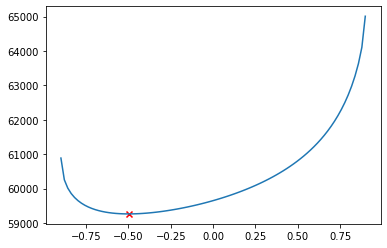

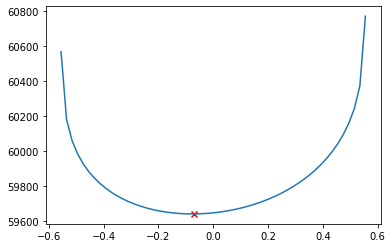

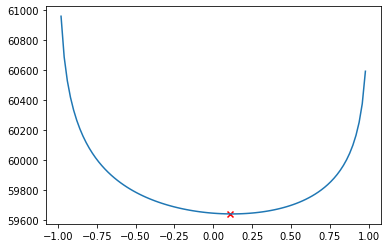

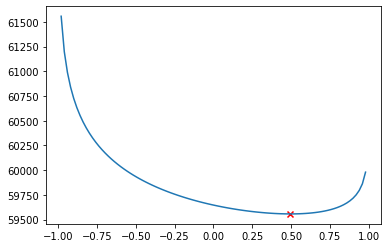

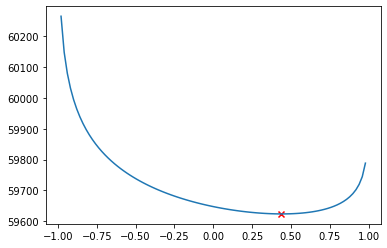

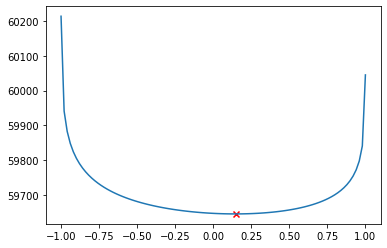

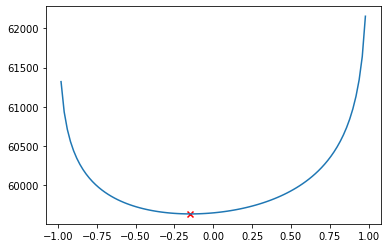

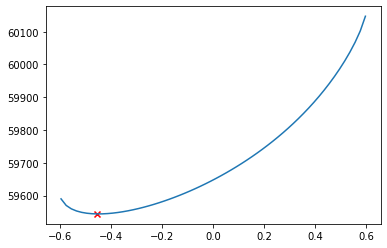

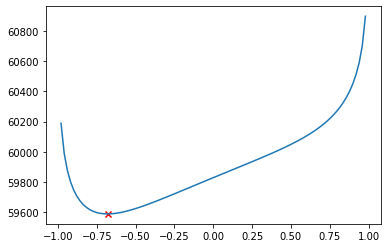

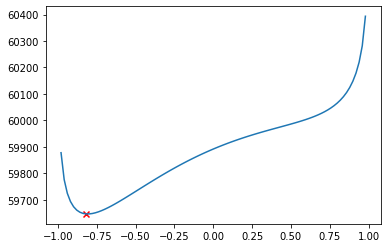

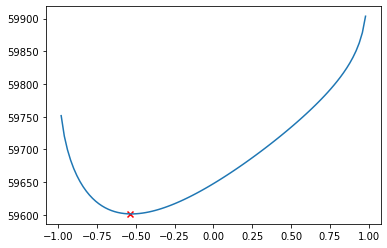

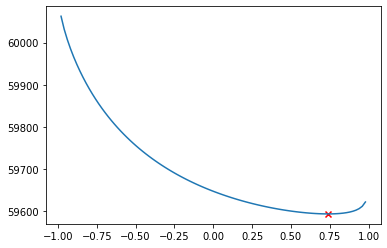

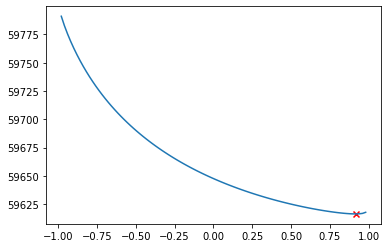

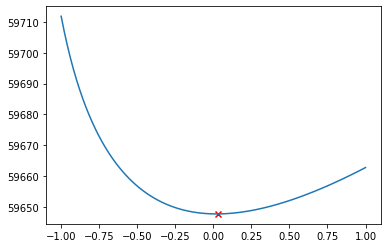

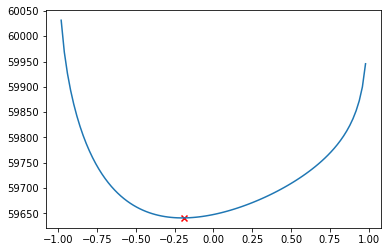

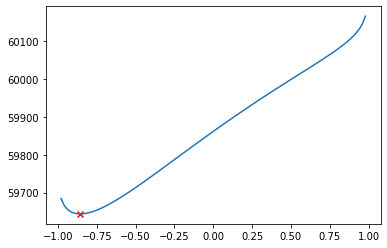

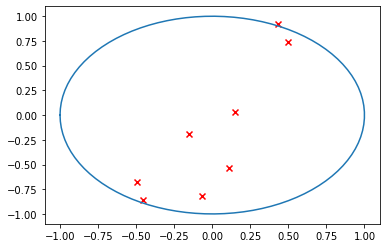

In [102]:
c1m,nllc1m = plotMin(x, nllc1)
c2m,nllc2m = plotMin(x, nllc2)
c3m,nllc3m = plotMin(x, nllc3)
c4m,nllc4m = plotMin(x, nllc4)
c5m,nllc5m = plotMin(x, nllc5)
c6m,nllc6m = plotMin(x, nllc6)
c7m,nllc7m = plotMin(x, nllc7)
c8m,nllc8m = plotMin(x, nllc8)

s1m,nlls1m = plotMin(x, nlls1)
s2m,nlls2m = plotMin(x, nlls2)
s3m,nlls3m = plotMin(x, nlls3)
s4m,nlls4m = plotMin(x, nlls4)
s5m,nlls5m = plotMin(x, nlls5)
s6m,nlls6m = plotMin(x, nlls6)
s7m,nlls7m = plotMin(x, nlls7)
s8m,nlls8m = plotMin(x, nlls8)

print(float(s8m))
print(float(nlls8m))

cm = {"1":c1m,
      "2":c2m,
      "3":c3m,
      "4":c4m,
      "5":c5m,
      "6":c6m,
      "7":c7m,
      "8":c8m
     }

sm = {"1":s1m,
      "2":s2m,
      "3":s3m,
      "4":s4m,
      "5":s5m,
      "6":s6m,
      "7":s7m,
      "8":s8m
     }
f,a=plt.subplots(1,1)
X = np.cos(np.linspace(-np.pi, np.pi,100))
Y = np.sin(np.linspace(-np.pi, np.pi,100))
a.plot(X,Y)
for i in range(1,9):
    cmi = cm[f"{i}"]
    smi = sm[f"{i}"]
    ctri = cTrue[f"{i}"]
    stri = sTrue[f"{i}"]
    diffc = cm[f"{i}"] - cTrue[f"{i}"]
    diffs = sm[f"{i}"] - sTrue[f"{i}"]
    
    a.scatter(cmi,smi,marker="x",color="red")
    print(f"{i}\t{round(cmi,3)}\t{round(ctri,3)}\t{round(diffc,3)}\t{round(smi,3)}\t{round(stri,3)}\t{round(diffs,3)}")

8	ciFit		ciTrue	pullci	siFit		siTrue	pullsi
1	0.0+-0.023	-0.895	38.357	-0.43+-0.838	-0.376	-0.066
2	0.0+-0.025	-0.374	14.725	-0.83+-0.087	-0.901	0.818
3	0.0+-0.045	0.301	-6.608	0.0+-1.415	-0.926	0.654
4	0.0+-0.045	0.948	-21.25	0.0+-0.264	-0.227	0.858
5	0.0+-0.076	0.932	-12.221	0.0+-0.673	0.283	-0.421
6	0.0+-0.095	0.411	-4.34	0.0+-0.798	0.884	-1.109
7	0.0+-0.033	-0.485	14.614	0.0+-0.71	0.858	-1.21
8	0.0+-0.043	-0.904	21.202	-0.79+-0.291	0.335	-3.862
{'1': Param(number=0, name='c1', value=0.0, error=0.023342086786260787, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), '2': Param(number=1, name='c2', value=0.0, error=0.025416223561302752, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), '3': Param(number=2, name='c3', value=0.0, error=0.04549076858897279, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=Fa

<ipython-input-103-d2823e91909b>:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, a = plt.subplots(1,1)
<ipython-input-103-d2823e91909b>:53: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f2,a2=plt.subplots(1,1)


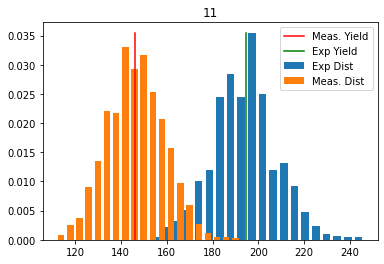

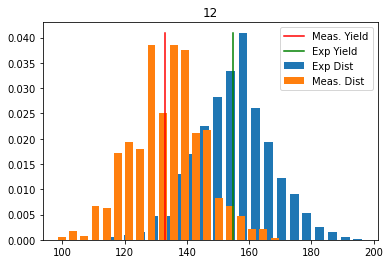

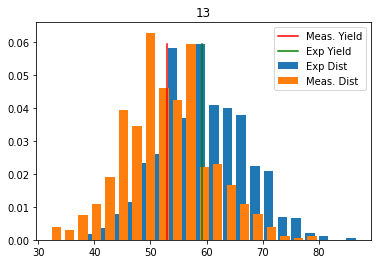

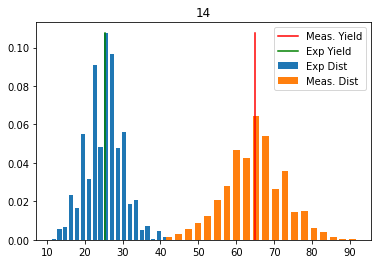

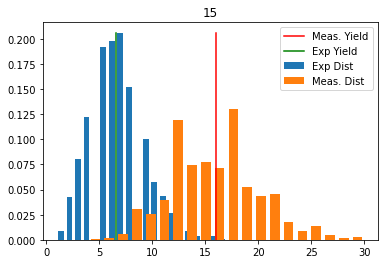

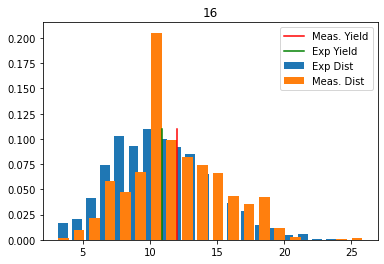

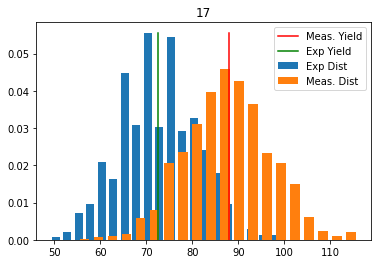

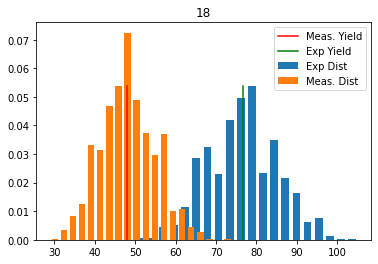

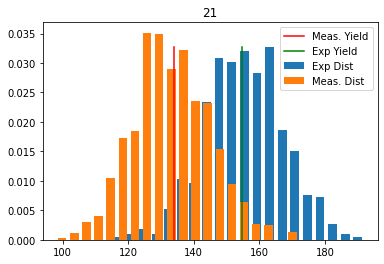

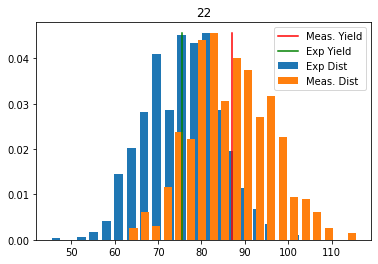

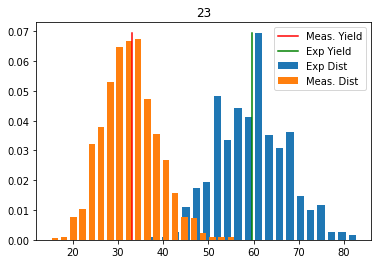

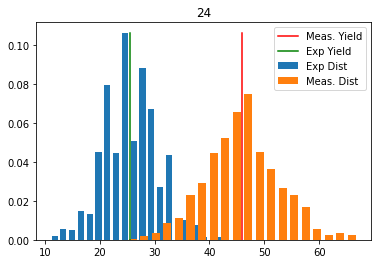

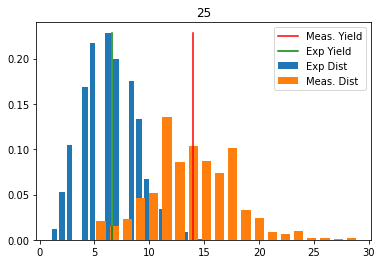

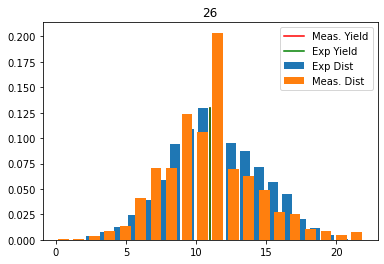

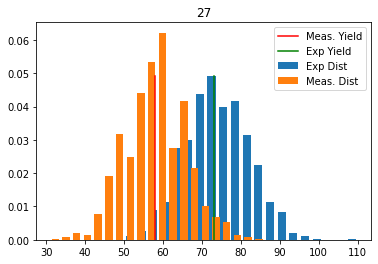

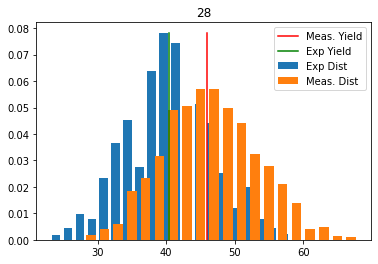

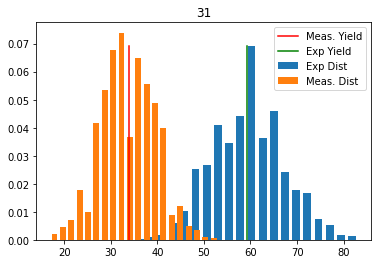

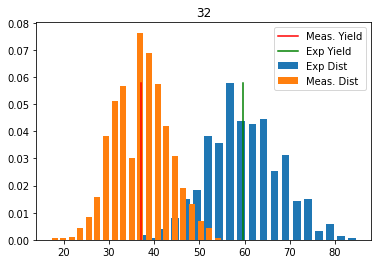

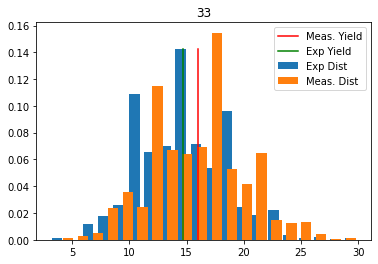

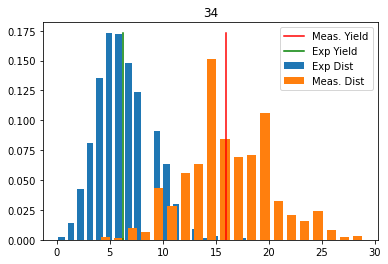

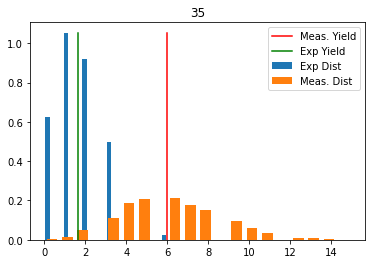

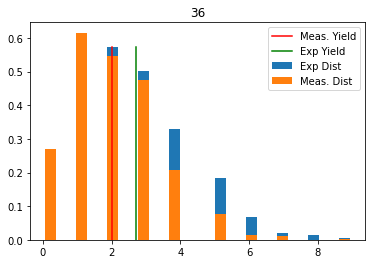

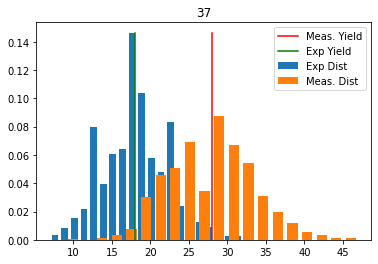

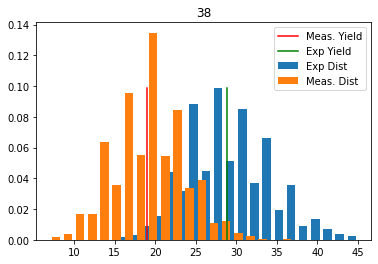

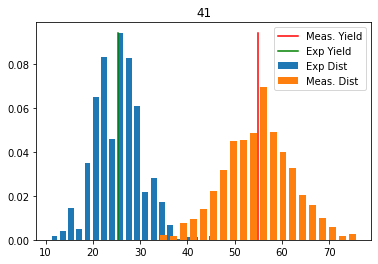

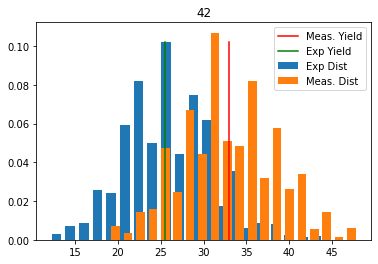

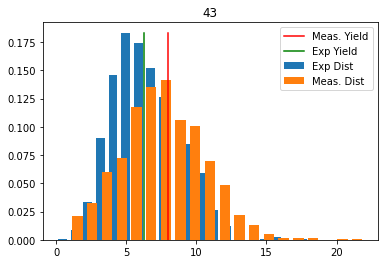

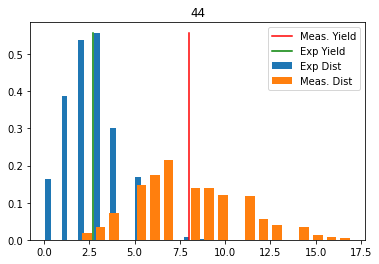

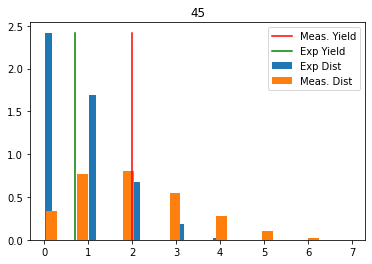

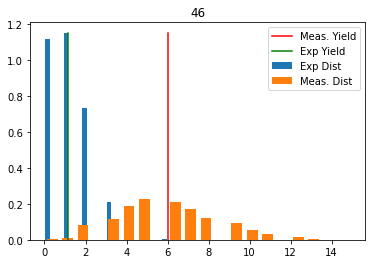

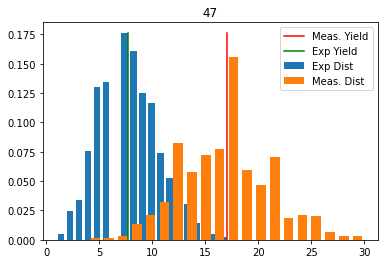

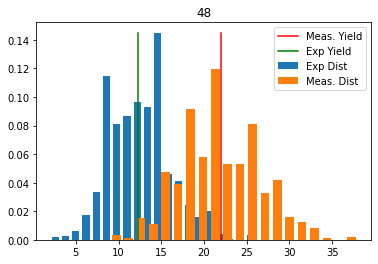

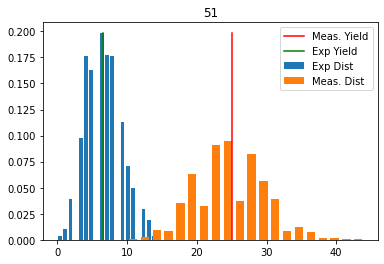

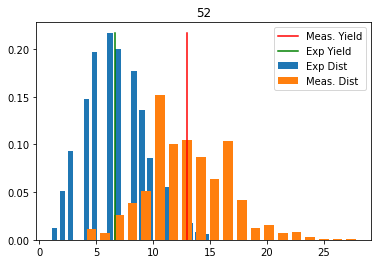

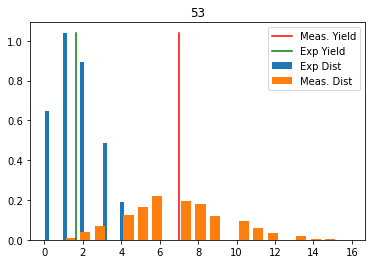

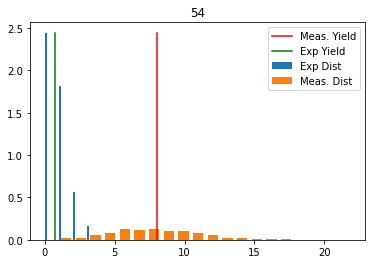

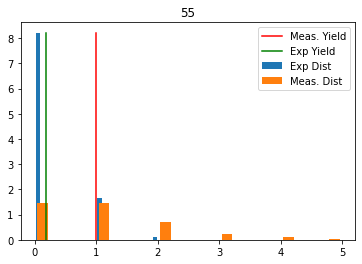

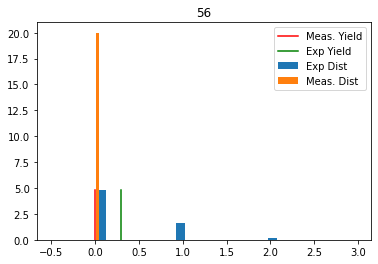

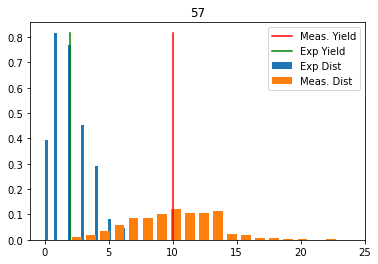

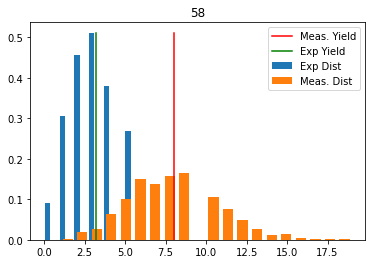

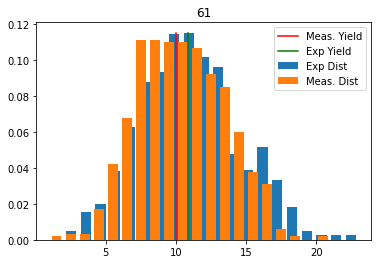

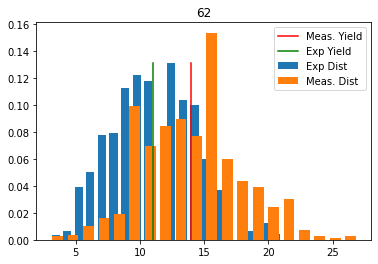

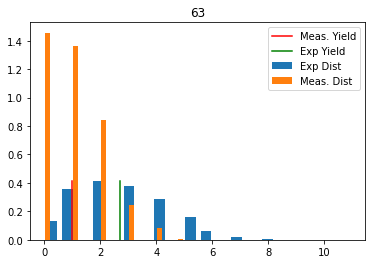

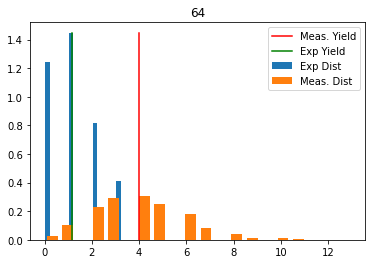

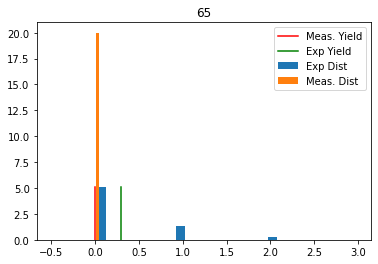

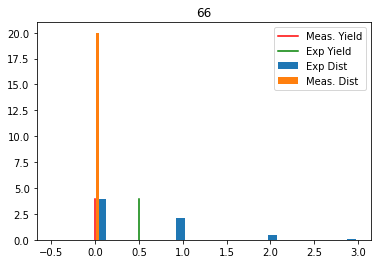

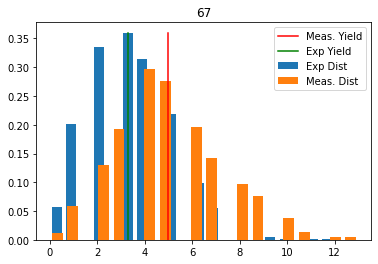

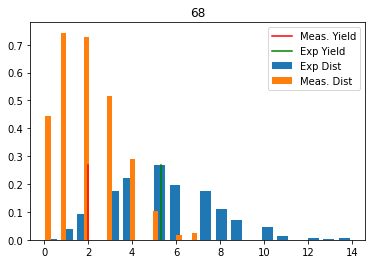

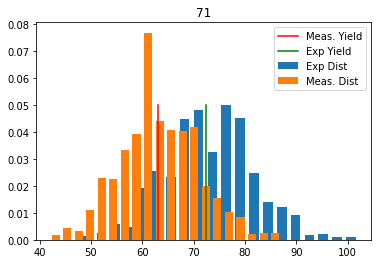

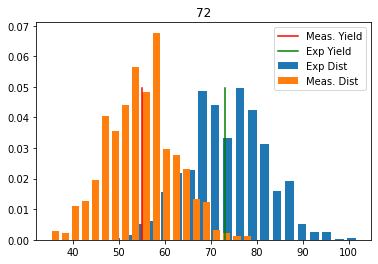

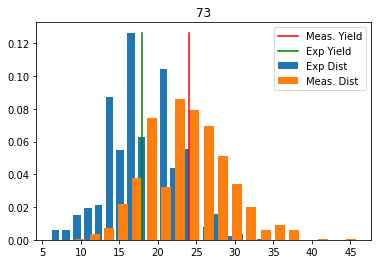

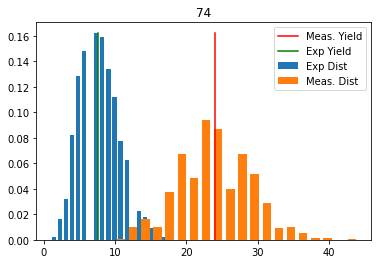

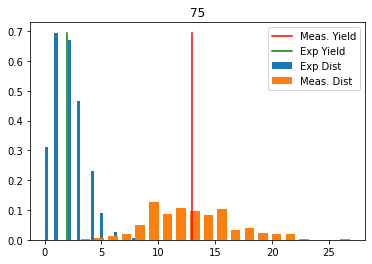

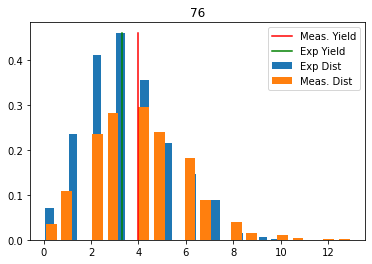

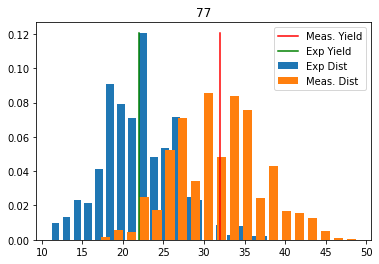

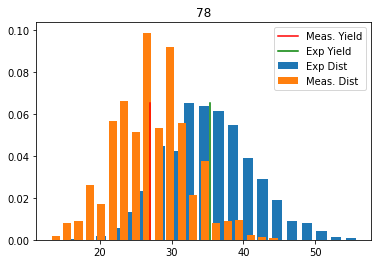

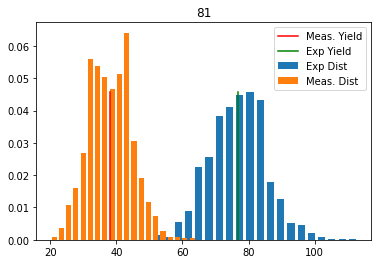

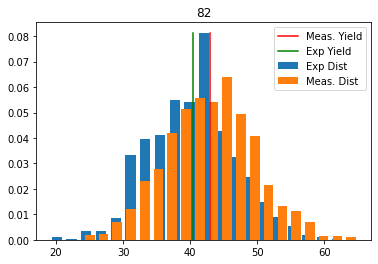

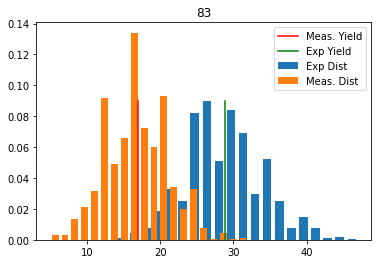

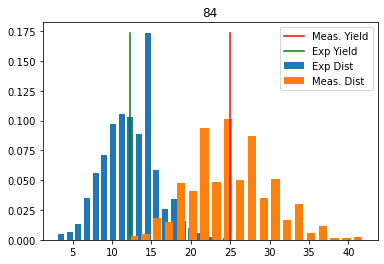

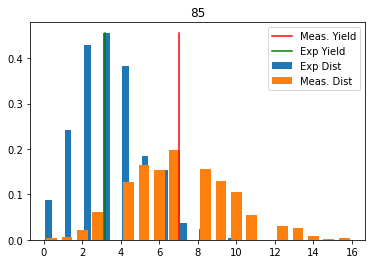

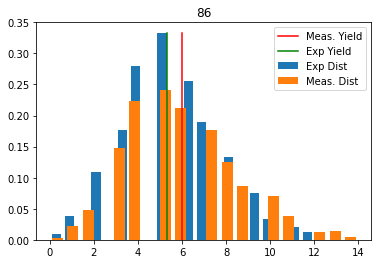

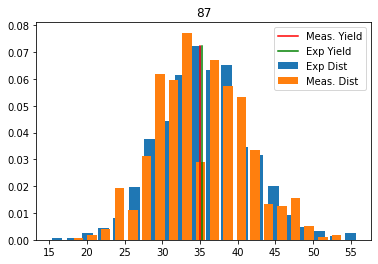

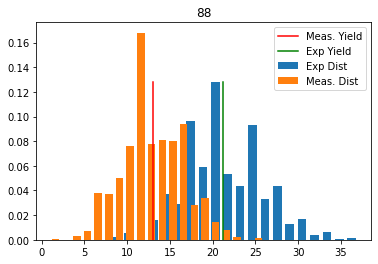

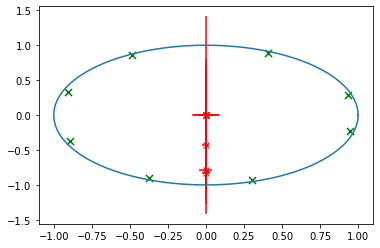

In [103]:

pullC = {}
pullS = {}
CFitvals = {}
SFitvals = {}
print(f"{i}\tciFit\t\tciTrue\tpullci\tsiFit\t\tsiTrue\tpullsi")
for key in cFit:
    pullC[key] = (cFit[key].value - cTrue[key])/cFit[key].error
    CFitvals[key] = cFit[key].value
    SFitvals[key] = sFit[key].value
    pullS[key] = (sFit[key].value - sTrue[key])/sFit[key].error
    
    print(f"{key}\t{round(cFit[key].value,3)}+-{round(cFit[key].error,3)}\t{round(cTrue[key],3)}\t{round(pullC[key],3)}\t{round(sFit[key].value,3)}+-{round(sFit[key].error,3)}\t{round(sTrue[key],3)}\t{round(pullS[key],3)}")

    
        
print(cFit)
print(sFit)

print(pullC)
print(pullS)



for i in range(1,9):
    for j in range(1,9):


        mu = eDT(i,j, CFitvals, SFitvals)*DT_Sum

        f, a = plt.subplots(1,1)
        x = np.random.poisson(mu, 1000)
        n, b = np.histogram(x, bins=20, density=True)
        c = 0.5*(b[1:] + b[:-1])
        w = 0.7*(c[1] - c[0])
        xm = M[f"{i}{j}"]
        

        ym = max(n)

        x0 = np.random.poisson(xm, 1000)
        n0, b0 = np.histogram(x0, bins=20, density=True)
        c0 = 0.5*(b0[1:] + b0[:-1])
        w0 = 0.7*(c0[1] - c0[0])


        a.bar(c, n, width=w, label=f"Exp Dist")
        a.bar(c0, n0, width=w0, label=f"Meas. Dist")
        a.plot([xm,xm], [0,ym], color="red", label="Meas. Yield")
        a.plot([mu,mu], [0,ym], color="green", label="Exp Yield")
        a.set_title(f"{i}{j}")
        a.legend()
    
f2,a2=plt.subplots(1,1)
th=np.linspace(0,2*np.pi,100)
_X = np.cos(th)
_Y = np.sin(th)
a2.plot(_X,_Y)
for key in CFitvals:
    a2.errorbar(cFit[key].value,sFit[key].value,xerr=cFit[key].error,yerr=sFit[key].error,marker="x",color="red")
    a2.scatter(ci[key],si[key],marker="x",s=50,color="green")



For the $B^\pm \to D h^\pm$, we have a similar amplitude to the $\psi(3770)$ amplitude (using the same symbols as for the $\psi(3770)$ amplitude.)
\begin{equation}
\begin{split}
A_{B^-} &= A + (x_- + i y_-) C \\
A_{B^+} &= C + (x_+ + i y_+) A 
\end{split}
\end{equation}
where $x_\pm + i y_\pm = r_B e^{i(\delta_B \pm \gamma)}$. So like the $CP$ yields, we have the expected yield for $B^\pm$ yields


\begin{equation}
\begin{split}
N_i^{-} &= N^{-}_\text{total} \frac{F_{i} + (x_-^2 + y_-^2) F_{-i} + 2 \sqrt{F_{i} F_{-i}} (x_- c_i - y_- s_i)}{\sum_i F_{i} + (x_-^2 + y_-^2) F_{-i} + 2 \sqrt{F_{i} F_{-i}} (x_- c_i - y_- s_i)} \\
N_i^{+} &= N^{+}_\text{total} \frac{F_{-i} + (x_+^2 + y_+^2) F_{i} + 2 \sqrt{F_{-i} F_{i}} (x_+ c_i - y_+ s_i)}{\sum_i F_{-i} + (x_+^2 + y_+^2) F_{i} + 2 \sqrt{F_{-i} F_{i}} (x_+ c_i - y_+ s_i)} 
 \end{split}
\end{equation}


In [104]:
def eBp(i, x, y,c,s):
    eBSum=0
    for j in range(1,9):
        eBSum+=(trueF(j) + (x**2 +y**2)*trueF(-j) + 2*(c[f"{j}"]*x - s[f"{j}"]*y)*(trueF(j)*trueF(-j))**0.5)/2
    return 0.5*(trueF(i) +(x**2 +y**2)* trueF(-i) + 2*(c[f"{i}"]*x - s[f"{i}"]*y)*(trueF(i)*trueF(-i))**0.5)/eBSum

def eBm(i, x, y,c,s):
    eBSum=0
    for j in range(1,9):
        eBSum+=(trueF(-j) + (x**2 +y**2)*trueF(j) + 2*(c[f"{j}"]*x - s[f"{j}"]*y)*(trueF(j)*trueF(-j))**0.5)/2
    return 0.5*(trueF(-i) +(x**2 +y**2)* trueF(i) + 2*(c[f"{i}"]*x - s[f"{i}"]*y)*(trueF(i)*trueF(-i))**0.5)/eBSum


print(ci)
print(N)
print(eBp(1,0.05,0.15,cTrue,sTrue))
print(eBm(1,0.05,0.15,cTrue,sTrue))



def nllB(xp,yp,xm,ym):
    nll = 0
    for i in range(1,9):
        xPlus = N["Bp2Dhp"][f"{i}"]# + N["KK"][f"{-i}"]
        muPlus = eBp(i, xp,yp,cTrue,sTrue)
        xMinus = N["Bm2Dhm"][f"{i}"]# + N["Kspi0"][f"{-i}"]
        
        muMinus = eBm(i, xm,ym,cTrue,sTrue)
        nll += -2 * scipy.stats.poisson(muPlus).logpmf(xPlus)
        nll += -2 * scipy.stats.poisson(muMinus).logpmf(xMinus)
    return nll


xpTrue = 0.05
ypTrue = -0.65

xmTrue = -0.15
ymTrue = 0.25


mB = iminuit.Minuit(nllB)
rB = mB.migrad()
print(rB)
print(mB.minos())
print(mB.hesse())
params = mB.params
xpFit, ypFit, xmFit, ymFit = params
print(f"x_+\t{round(xpFit.value,3)}+-{round(xpFit.error,3)}\t{xpTrue}\t{round((xpFit.value - xpTrue)/xpFit.error,3)}")
print(f"y_+\t{round(ypFit.value,3)}+-{round(ypFit.error,3)}\t{ypTrue}\t{round((ypFit.value - ypTrue)/ypFit.error,3)}")
print(f"x_-\t{round(xmFit.value,3)}+-{round(xmFit.error,3)}\t{xmTrue}\t{round((xmFit.value - xmTrue)/xmFit.error,3)}")
print(f"y_-\t{round(ymFit.value,3)}+-{round(ymFit.error,3)}\t{ymTrue}\t{round((ymFit.value - ymTrue)/ymFit.error,3)}")

{'1': -0.8953307358368907, '2': -0.3742523393240013, '3': 0.30058859433636675, '4': 0.9484870400765844, '5': 0.9317279163728642, '6': 0.4105983664259624, '7': -0.4849299380759217, '8': -0.9043300436820767}
{'KK': {'1': 1047, '2': 533, '3': 144, '4': 81, '5': 32, '6': 33, '7': 345, '8': 313}, 'Kspi0': {'1': 344, '2': 452, '3': 184, '4': 253, '5': 84, '6': 44, '7': 254, '8': 110}, 'Kppim': {'1': 6219, '-1': 1298, '2': 5069, '-2': 312, '3': 1763, '-3': 61, '4': 1630, '-4': 193, '5': 576, '-5': 71, '6': 386, '-6': 33, '7': 3068, '-7': 234, '8': 1939, '-8': 605}, 'Bp2Dhp': {'1': 601, '2': 435, '3': 144, '4': 167, '5': 73, '6': 29, '7': 254, '8': 197}, 'Bm2Dhm': {'1': 616, '2': 452, '3': 146, '4': 134, '5': 41, '6': 29, '7': 237, '8': 245}}
0.30090470089103816
0.3046678144697547


<ipython-input-104-86cf42aa5c6e>:41: InitialParamWarning: Parameter xp does not have neither initial value nor limits.
  mB = iminuit.Minuit(nllB)
<ipython-input-104-86cf42aa5c6e>:41: InitialParamWarning: Parameter yp does not have neither initial value nor limits.
  mB = iminuit.Minuit(nllB)
<ipython-input-104-86cf42aa5c6e>:41: InitialParamWarning: Parameter xm does not have neither initial value nor limits.
  mB = iminuit.Minuit(nllB)
<ipython-input-104-86cf42aa5c6e>:41: InitialParamWarning: Parameter ym does not have neither initial value nor limits.
  mB = iminuit.Minuit(nllB)
<ipython-input-104-86cf42aa5c6e>:41: InitialParamWarning: errordef is not given, defaults to 1.
  mB = iminuit.Minuit(nllB)
<ipython-input-104-86cf42aa5c6e>:41: IMinuitWarning: Setting print_level >=3 has the side-effect of setting the level globally for all Minuit instances
  mB = iminuit.Minuit(nllB)


------------------------------------------------------------------
| FCN = 5.014e+04               |      Ncalls=89 (89 total)      |
| EDM = 6.56e-07 (Goal: 0.0002) |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
--------------